## Imports

In [1]:
import gzip, re, collections, statistics, math, lzma, tempfile, shutil
import zstandard as zstd
from pathlib import Path
from enum import IntEnum

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from scipy.signal import butter, filtfilt, detrend, savgol_filter

from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, MultiTaskElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from catboost import CatBoostRegressor
from pyEDM import EmbedDimension

import tqdm.notebook as tqdm
from typing import Callable, Any
from functools import partial

In [2]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 42
RESULTS_DIR = "../experiment-results/two-imu-one-dyn-syst/"

## Read Data

In [3]:
DATA_DIR = '../data/two-imu-one-dyn-syst/'
acc_1_df = pd.read_csv(DATA_DIR + 'acc-1.csv')
gyr_1_df = pd.read_csv(DATA_DIR + 'gyr-1.csv')

acc_2_df = pd.read_csv(DATA_DIR + 'acc-2.csv')
gyr_2_df = pd.read_csv(DATA_DIR + 'gyr-2.csv')

In [4]:
for df in (acc_1_df, gyr_1_df, acc_2_df, gyr_2_df):
    print(df.shape)
    print(df.head())

(38122, 5)
                  time  seconds_elapsed         z         y         x
0  1747571324974342100         0.078342 -0.012631 -0.002333  0.001062
1  1747571324990302500         0.094302 -0.036629 -0.025879 -0.015898
2  1747571325006293500         0.110293  0.025593  0.012618 -0.037439
3  1747571325022253800         0.126254 -0.065401  0.003188  0.009917
4  1747571325038244900         0.142245 -0.017526  0.008071 -0.009710
(38112, 5)
                  time  seconds_elapsed         z         y         x
0  1747571324967048400         0.071048  0.001222 -0.003054 -0.001222
1  1747571324982368300         0.086368  0.000611 -0.001222 -0.001222
2  1747571324998359000         0.102359 -0.002443 -0.000611 -0.001833
3  1747571325014319600         0.118320  0.001222 -0.003665  0.000611
4  1747571325030310400         0.134310  0.001222 -0.004276  0.000000
(60952, 5)
                  time  seconds_elapsed         z         y         x
0  1747571324508624600         0.121625  0.062182 -0.0004

Rename columns

In [5]:
acc_columns_mapping = {'x': 'acc_x', 'y': 'acc_y', 'z': 'acc_z'}
gyr_columns_mapping = {'x': 'gyr_x', 'y': 'gyr_y', 'z': 'gyr_z'}

acc_1_df.rename(columns=acc_columns_mapping, inplace=True)
gyr_1_df.rename(columns=gyr_columns_mapping, inplace=True)

acc_2_df.rename(columns=acc_columns_mapping, inplace=True)
gyr_2_df.rename(columns=gyr_columns_mapping, inplace=True)

Plot data

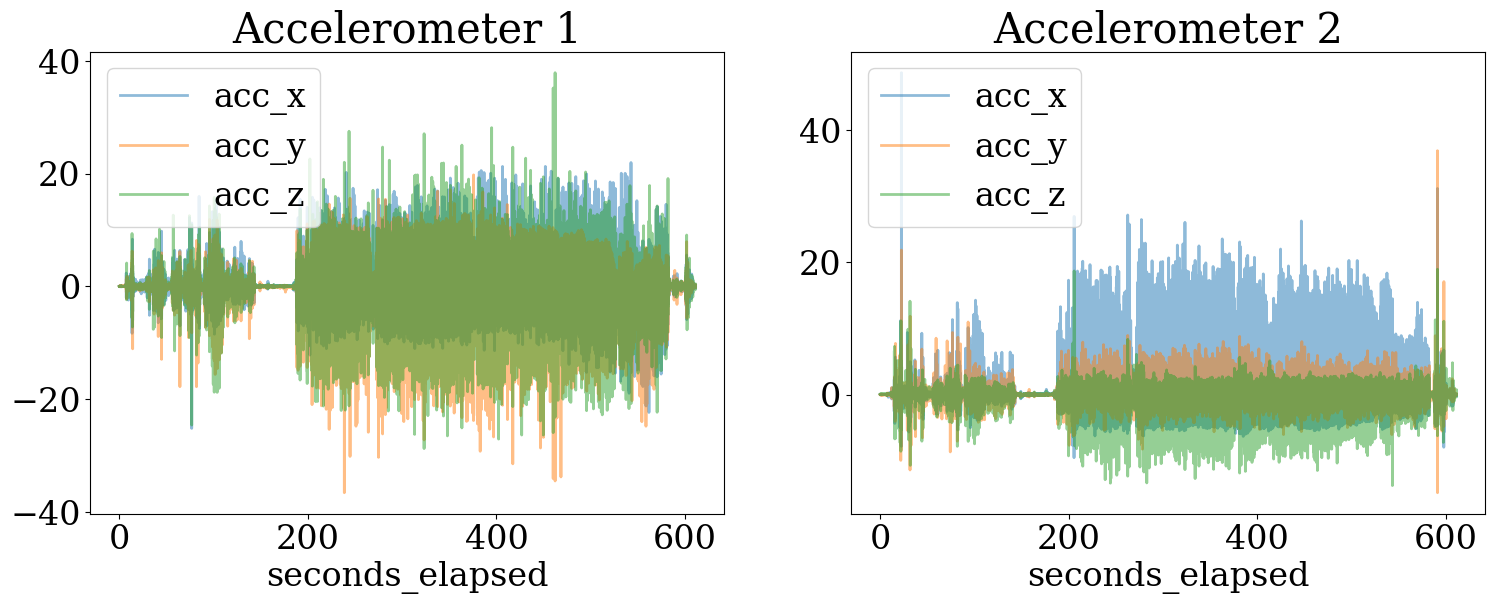

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

acc_1_df.plot(x='seconds_elapsed', y=list(acc_columns_mapping.values()), alpha=0.5, title='Accelerometer 1', ax=axes[0])
acc_2_df.plot(x='seconds_elapsed', y=list(acc_columns_mapping.values()), alpha=0.5, title='Accelerometer 2', ax=axes[1])
plt.show()

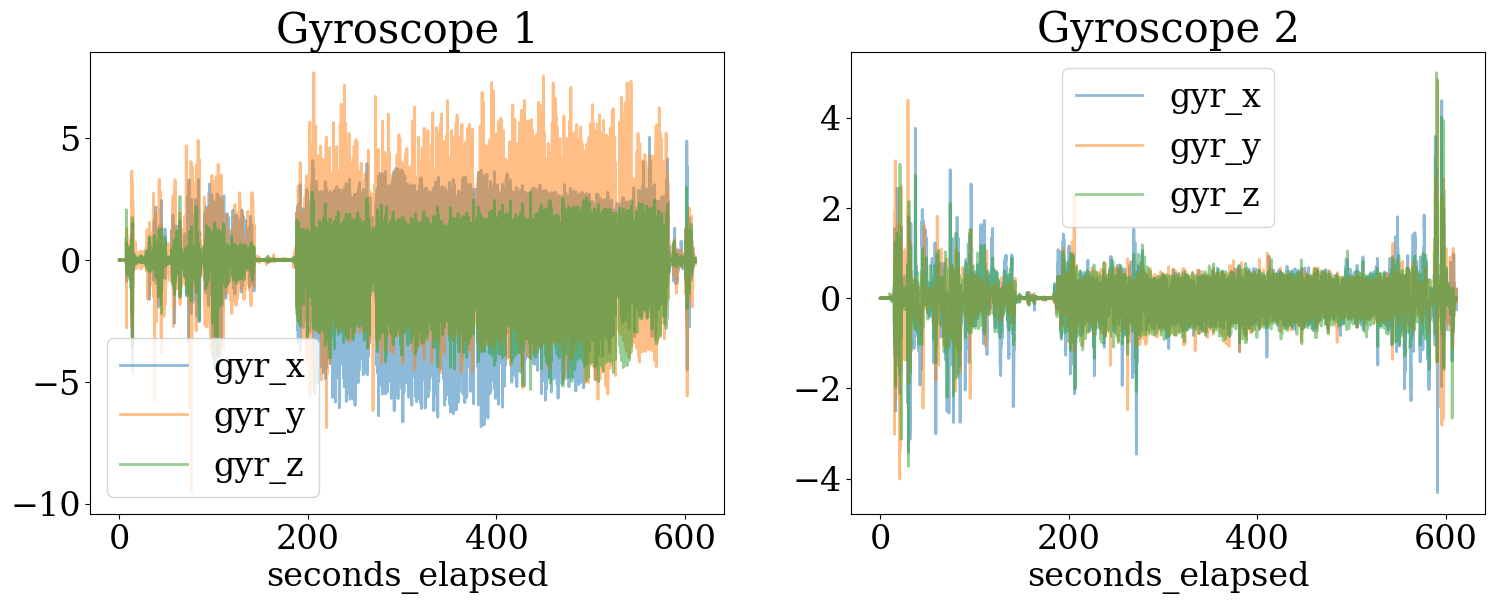

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

gyr_1_df.plot(x='seconds_elapsed', y=list(gyr_columns_mapping.values()), alpha=0.5, title='Gyroscope 1', ax=axes[0])
gyr_2_df.plot(x='seconds_elapsed', y=list(gyr_columns_mapping.values()), alpha=0.5, title='Gyroscope 2', ax=axes[1])
plt.show()

Join data from the same system

Note that tolerance is different because system 1 has a 60 Hz frequency while the system 2 has a 100 Hz frequency

0.017 $\approx 1/60$ 

In [8]:
eps = 1e3

df_1 = pd.merge_asof(acc_1_df, gyr_1_df, on='seconds_elapsed', direction='nearest', tolerance=1/60 + eps)
df_2 = pd.merge_asof(acc_2_df, gyr_2_df, on='seconds_elapsed', direction='nearest', tolerance=1/100 + eps)

In [9]:
assert len(df_1) == len(acc_1_df)
assert len(df_2) == len(acc_2_df)

In [10]:
print(df_1.shape)
df_1.head()

(38122, 9)


,time_x,seconds_elapsed,acc_z,acc_y,acc_x,time_y,gyr_z,gyr_y,gyr_x
0,1747571324974342100,0.078342,-0.012631,-0.002333,0.001062,1747571324967048400,0.001222,-0.003054,-0.001222
1,1747571324990302500,0.094302,-0.036629,-0.025879,-0.015898,1747571324982368300,0.000611,-0.001222,-0.001222
2,1747571325006293500,0.110293,0.025593,0.012618,-0.037439,1747571324998359000,-0.002443,-0.000611,-0.001833
3,1747571325022253800,0.126254,-0.065401,0.003188,0.009917,1747571325014319600,0.001222,-0.003665,0.000611
4,1747571325038244900,0.142245,-0.017526,0.008071,-0.009710,1747571325030310400,0.001222,-0.004276,0.000000


In [11]:
print(df_2.shape)
df_2.head()

(60952, 9)


,time_x,seconds_elapsed,acc_z,acc_y,acc_x,time_y,gyr_z,gyr_y,gyr_x
0,1747571324508624600,0.121625,0.062182,-0.000405,0.008137,1747571324508655000,-0.000533,0.001598,0.0
1,1747571324518604000,0.131604,0.057374,0.013954,0.001110,1747571324518634500,-0.000533,0.001598,0.0
2,1747571324528583200,0.141583,0.047779,0.016342,0.008448,1747571324528644000,-0.000533,0.001598,0.0
3,1747571324538562300,0.151562,0.047760,0.009153,-0.005762,1747571324538593000,-0.000533,0.001598,0.0
4,1747571324548541700,0.161542,0.062106,0.011541,0.011153,1747571324548602600,-0.000533,0.001598,0.0


In [12]:
df_1.drop(columns=['time_x', 'time_y'], inplace=True)
df_2.drop(columns=['time_x', 'time_y'], inplace=True)

Cut the data by time: drop first and last minute

In [13]:
min_t = 200
max_t = min(df_1.seconds_elapsed.max(), df_2.seconds_elapsed.max()) - 60

df_1 = df_1.query(f"{min_t} <= seconds_elapsed <= {max_t}").reset_index(drop=True)
df_2 = df_2.query(f"{min_t} <= seconds_elapsed <= {max_t}").reset_index(drop=True)

Align frequencies

In [14]:
df_merged = pd.concat(
    (df_1.assign(source=1), df_2.assign(source=2)),
    axis=0
)\
.reset_index(drop=True)\
.sort_values(by='seconds_elapsed', ignore_index=True)

df_merged.iloc[df_merged.query("source == 1").index, 1:-1] = None
df_merged = df_merged.set_index('seconds_elapsed')

In [15]:
df_interpolated = df_merged.interpolate(method='index')
df_2_interp = df_interpolated.query("source == 1").drop(columns='source').reset_index()

In [16]:
assert df_1.shape == df_2_interp.shape

## Vizualization

2D

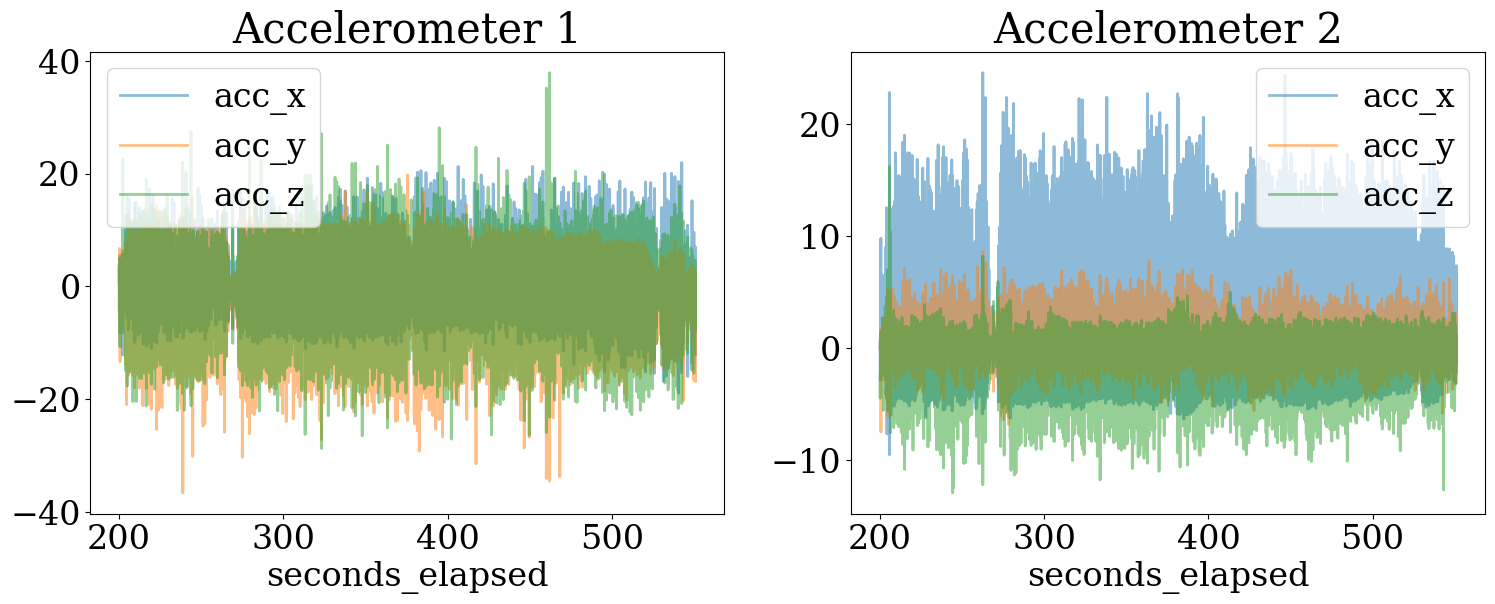

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

df_1.plot(x='seconds_elapsed', y=list(acc_columns_mapping.values()), alpha=0.5, title='Accelerometer 1', ax=axes[0])
df_2_interp.plot(x='seconds_elapsed', y=list(acc_columns_mapping.values()), alpha=0.5, title='Accelerometer 2', ax=axes[1])
plt.show()

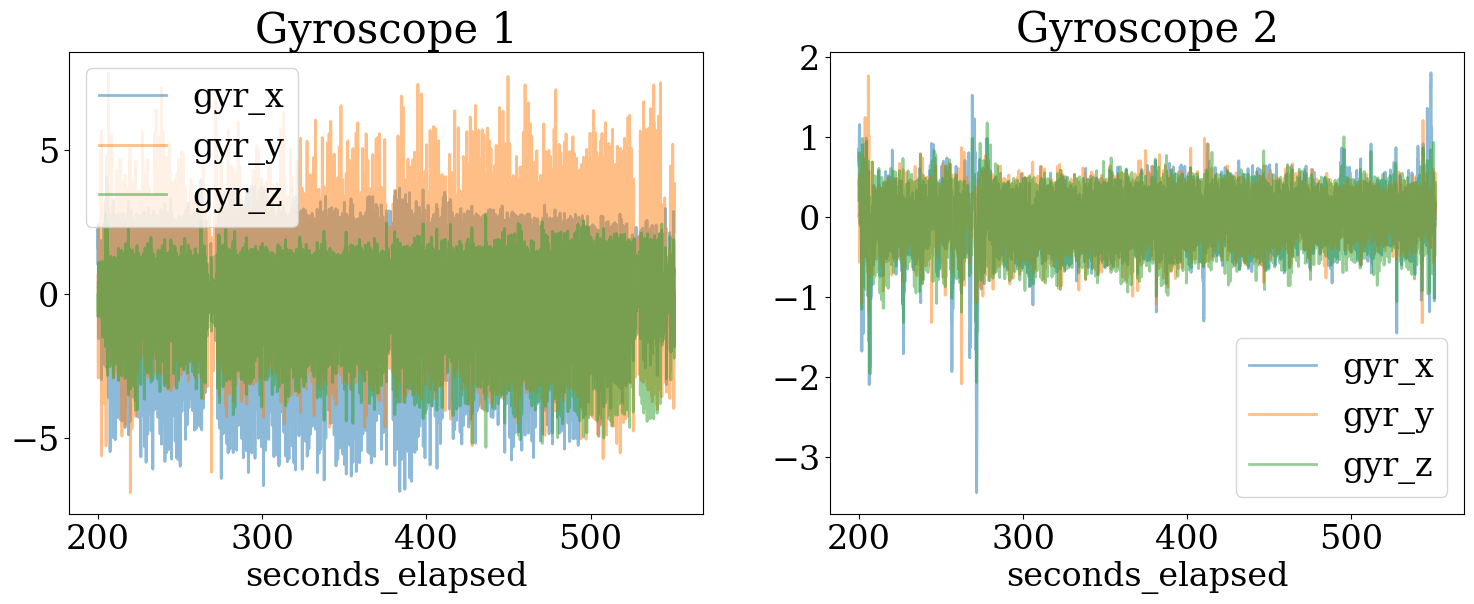

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

df_1.plot(x='seconds_elapsed', y=list(gyr_columns_mapping.values()), alpha=0.5, title='Gyroscope 1', ax=axes[0])
df_2_interp.plot(x='seconds_elapsed', y=list(gyr_columns_mapping.values()), alpha=0.5, title='Gyroscope 2', ax=axes[1])
plt.show()

3D

Plot function

In [21]:
def plot_imu_phase_trajectory(acc_data: np.ndarray, gyro_data: np.ndarray, alpha: float = 0.4, scatter: bool = False):
    if acc_data.shape[1] != 3 or gyro_data.shape[1] != 3:
        raise ValueError("Each input must have shape (N, 3).")

    N_acc = acc_data.shape[0]
    N_gyro = gyro_data.shape[0]
    if N_acc != N_gyro:
        print("Warning: Accelerometer and gyroscope have different lengths.")
    N = min(N_acc, N_gyro)

    # Truncate to the same length if needed
    acc = acc_data[:N, :]
    gyro = gyro_data[:N, :]

    fig = plt.figure(figsize=(12, 5))

    # Accelerometer 3D trajectory
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    if scatter:
        ax1.scatter(
            acc[:, 0],
            acc[:, 1],
            acc[:, 2],
            color="blue",
            linewidth=1.0,
            alpha=alpha
        )
    else:
        ax1.plot(
            acc[:, 0],
            acc[:, 1],
            acc[:, 2],
            color="blue",
            linewidth=1.0,
            alpha=alpha
        )
    ax1.set_xlabel('Accel X (m/s²)')
    ax1.set_ylabel('Accel Y (m/s²)')
    ax1.set_zlabel('Accel Z (m/s²)')
    ax1.set_title('Accelerometer 3D Phase Trajectory')

    # Gyroscope 3D trajectory
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    if scatter:
        ax2.scatter(
            gyro[:, 0],
            gyro[:, 1],
            gyro[:, 2],
            color="blue",
            linewidth=1.0,
            alpha=alpha
        )
    else:
        ax2.plot(
            gyro[:, 0],
            gyro[:, 1],
            gyro[:, 2],
            color="blue",
            linewidth=1.0,
            alpha=alpha
        )
    ax2.set_xlabel('Gyro X (rad/s)')
    ax2.set_ylabel('Gyro Y (rad/s)')
    ax2.set_zlabel('Gyro Z (rad/s)')
    ax2.set_title('Gyroscope 3D Phase Trajectory')

    # ax1.view_init(elev=30, azim=45)
    # ax2.view_init(elev=20, azim=70)

    plt.tight_layout()
    plt.show()

In [29]:
def color_plot_imu_phase_trajectory(acc_data: np.ndarray, gyro_data: np.ndarray, alpha: float = 0.4, scatter: bool = False):
    if acc_data.shape[1] != 3 or gyro_data.shape[1] != 3:
        raise ValueError("Each input must have shape (N, 3).")

    N = min(len(acc_data), len(gyro_data))
    time_idx = np.linspace(0, 1, N)

    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    for i in range(N - 1):
        if scatter:
            ax1.plot(
                acc_data[i, 0],  # x-coordinates: [ax_i, ax_{i+1}]
                acc_data[i, 1],  # y-coordinates: [ay_i, ay_{i+1}]
                acc_data[i, 2],  # z-coordinates: [az_i, az_{i+1}]
                color=plt.cm.viridis(time_idx[i]),  # colormap “viridis” indexed by time
                linewidth=1.0
            )
            ax2.plot(
                gyro_data[i, 0],  # x-coordinates: [ax_i, ax_{i+1}]
                gyro_data[i, 1],  # y-coordinates: [ay_i, ay_{i+1}]
                gyro_data[i, 2],  # z-coordinates: [az_i, az_{i+1}]
                color=plt.cm.viridis(time_idx[i]),  # colormap “viridis” indexed by time
                linewidth=1.0
            )
        else:
            ax1.plot(
                acc_data[i : i + 2, 0],  # x-coordinates: [ax_i, ax_{i+1}]
                acc_data[i : i + 2, 1],  # y-coordinates: [ay_i, ay_{i+1}]
                acc_data[i : i + 2, 2],  # z-coordinates: [az_i, az_{i+1}]
                color=plt.cm.viridis(time_idx[i]),  # colormap “viridis” indexed by time
                linewidth=1.0,
                alpha=alpha
            )
            ax2.plot(
                gyro_data[i : i + 2, 0],  # x-coordinates: [ax_i, ax_{i+1}]
                gyro_data[i : i + 2, 1],  # y-coordinates: [ay_i, ay_{i+1}]
                gyro_data[i : i + 2, 2],  # z-coordinates: [az_i, az_{i+1}]
                color=plt.cm.viridis(time_idx[i]),  # colormap “viridis” indexed by time
                linewidth=1.0,
                alpha=alpha
            )
    
    ax1.set_xlabel('Accel X (m/s²)')
    ax1.set_ylabel('Accel Y (m/s²)')
    ax1.set_zlabel('Accel Z (m/s²)')
    ax1.set_title('Accelerometer 3D Phase Trajectory')

    ax2.set_xlabel('Gyro X (rad/s)')
    ax2.set_ylabel('Gyro Y (rad/s)')
    ax2.set_zlabel('Gyro Z (rad/s)')
    ax2.set_title('Gyroscope 3D Phase Trajectory')

    # ax1.view_init(elev=30, azim=45)
    # ax2.view_init(elev=20, azim=70)

    plt.tight_layout()
    plt.show()

Time series smoothing functions

In [26]:
def moving_average(data: np.ndarray, window_size: int) -> np.ndarray:
    filtered = np.zeros_like(data)
    cumsum = np.cumsum(data, axis=0)
    
    # For i from 0 to N-1, sum over last window_size samples:
    #   sum_i = cumsum[i] - cumsum[i - window_size], taking care of i < window_size
    for i in range(data.shape[0]):
        start_idx = max(0, i - window_size + 1)
        if start_idx == 0:
            window_sum = cumsum[i]
            count = i + 1
        else:
            window_sum = cumsum[i] - cumsum[start_idx - 1]
            count = window_size
        filtered[i] = window_sum / count
    return filtered


def savgol_smooth(data: np.ndarray, window_size: int, polyorder: int = 3) -> np.ndarray:
    if window_size % 2 == 0:
        raise ValueError("window_length must be odd")
    if polyorder >= window_size:
        raise ValueError("polyorder must be < window_length")
    
    # Apply the filter axis by axis
    filtered = np.zeros_like(data)
    for axis in range(data.shape[1]):  # axis=0,1,2
        filtered[:, axis] = savgol_filter(
            data[:, axis],
            window_length=window_size,
            polyorder=polyorder,
            mode='interp'  # or 'mirror' to reduce end‐effects
        )
    return filtered


def butter_lowpass_filter(data: np.ndarray, cutoff: float = 5, fs: float = 60, order: int = 4) -> np.ndarray:
    # Normalize cutoff frequency: digital frequency = cutoff / (fs/2)
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    
    # Get IIR filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Apply filter with zero phase distortion via filtfilt
    filtered = np.zeros_like(data)
    for axis in range(data.shape[1]):
        filtered[:, axis] = filtfilt(b, a, data[:, axis])
    return filtered

Plot device 1

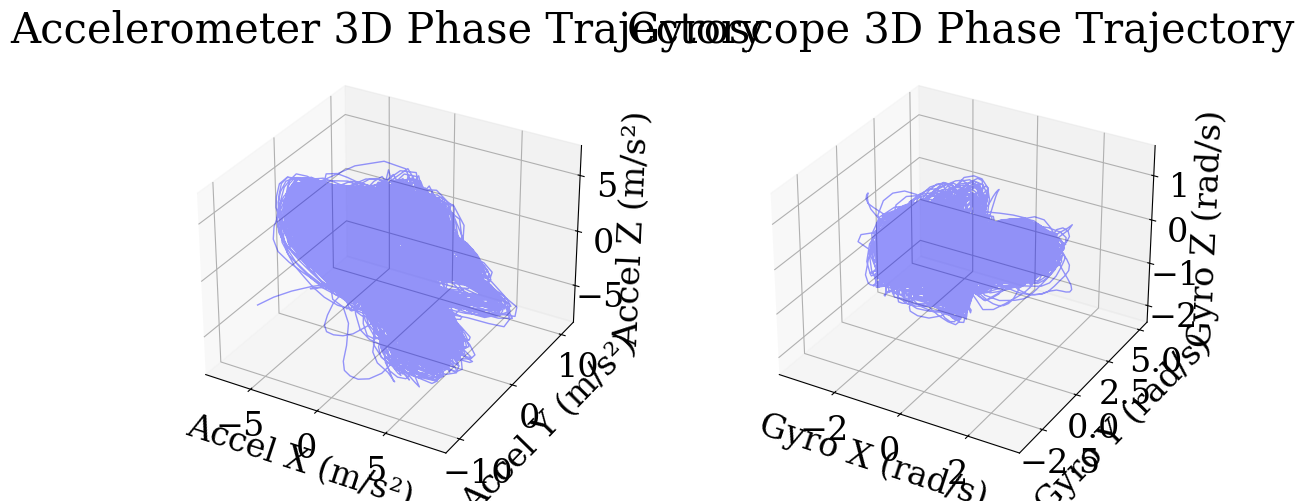

In [27]:
acc_1 = df_1[list(acc_columns_mapping.values())].values
gyr_1 = df_1[list(gyr_columns_mapping.values())].values

window = 21
acc_smoothed = savgol_smooth(acc_1, window_size=window)
gyro_smoothed = savgol_smooth(gyr_1, window_size=window)
# acc_smoothed = butter_lowpass_filter(acc_1)
# gyro_smoothed = butter_lowpass_filter(gyr_1)

plot_imu_phase_trajectory(acc_smoothed, gyro_smoothed, scatter=False, alpha=0.4)

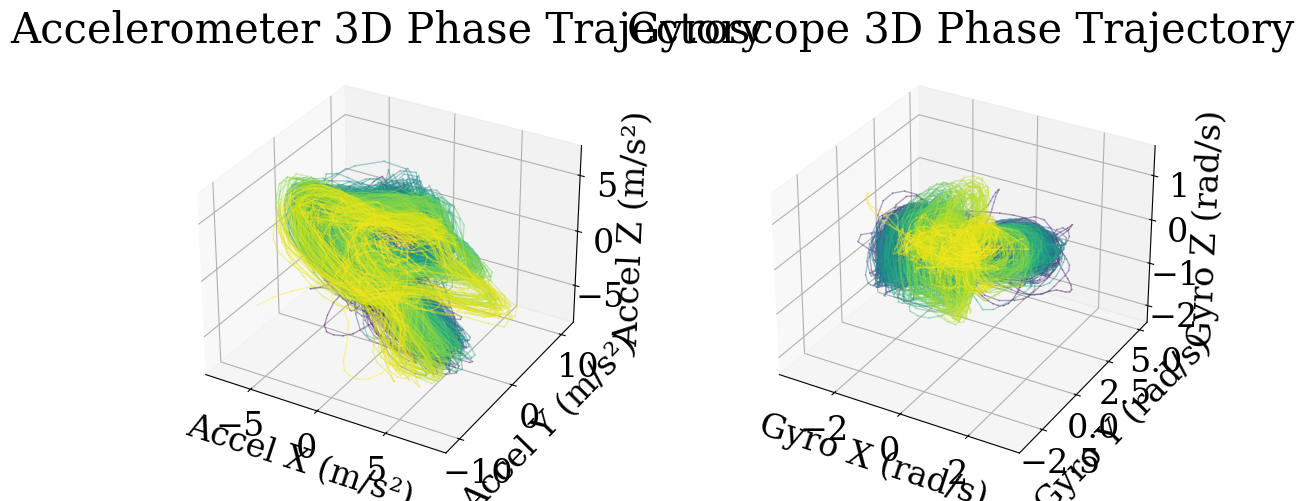

In [30]:
color_plot_imu_phase_trajectory(acc_smoothed, gyro_smoothed, scatter=False, alpha=0.4)

Plot device 2

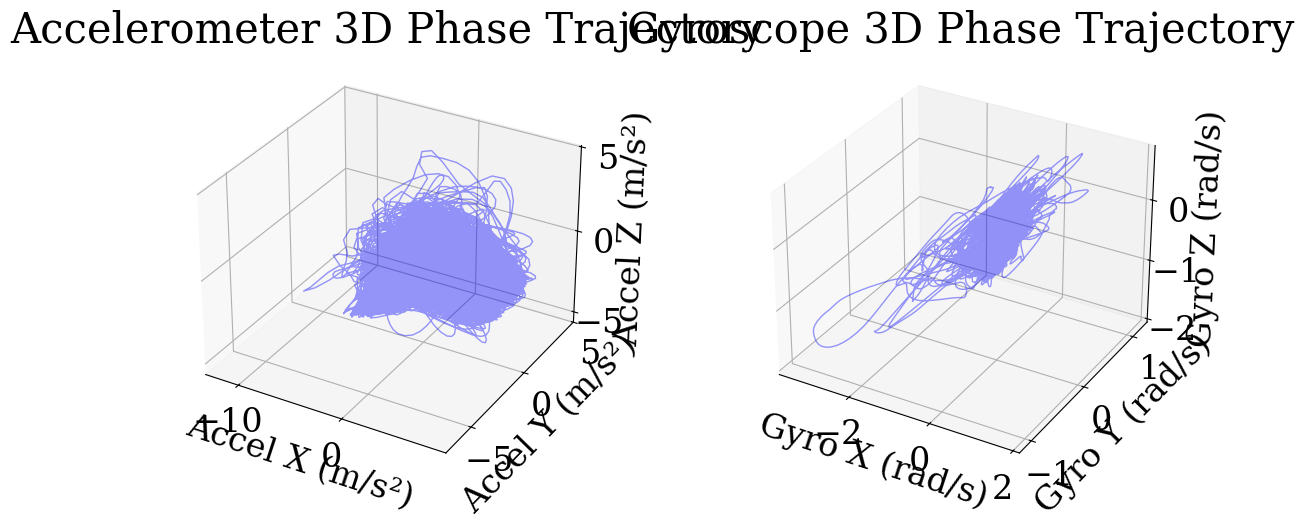

In [39]:
acc_2 = df_2_interp[list(acc_columns_mapping.values())].values
gyr_2 = df_2_interp[list(gyr_columns_mapping.values())].values

window = 21
acc_smoothed_2 = savgol_smooth(acc_2, window_size=window)
gyro_smoothed_2 = savgol_smooth(gyr_2, window_size=window)
# acc_smoothed_2 = butter_lowpass_filter(acc_2)
# gyro_smoothed_2 = butter_lowpass_filter(gyr_2)

plot_imu_phase_trajectory(acc_smoothed_2, gyro_smoothed_2, scatter=False, alpha=0.4)

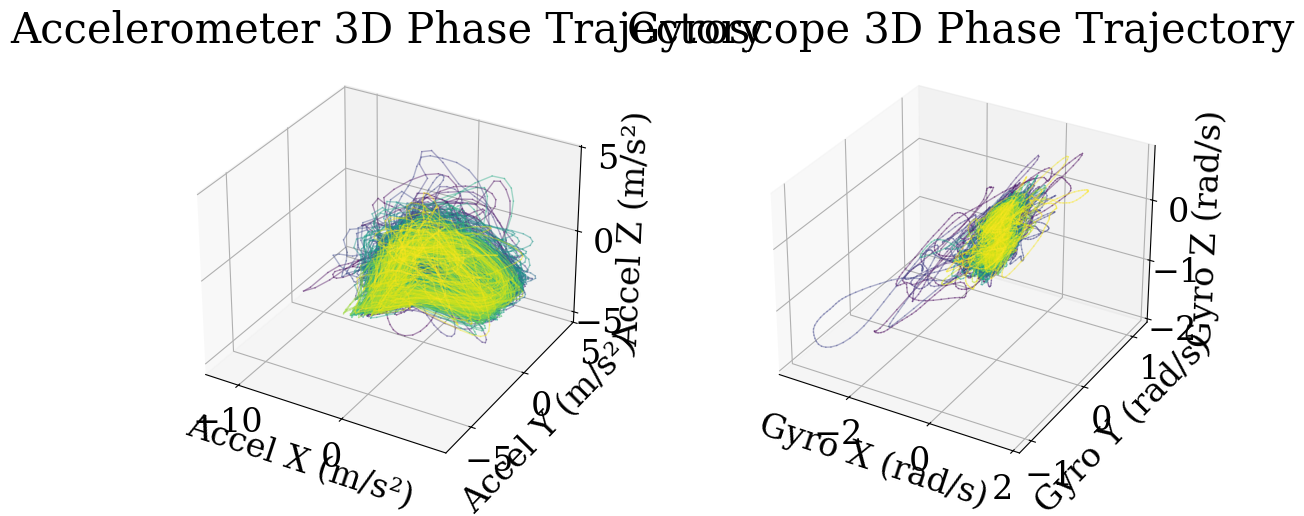

In [40]:
color_plot_imu_phase_trajectory(acc_smoothed_2, gyro_smoothed_2, scatter=False, alpha=0.4)

Apply ICA

In [58]:
acc_1_ica = FastICA(n_components=3, random_state=SEED).fit_transform(acc_1)
gyr_1_ica = FastICA(n_components=3, random_state=SEED).fit_transform(gyr_1)

# acc_1_ica_v1 = np.lib.stride_tricks.sliding_window_view(acc_1_ica[..., 0], 3)
acc_1_ica_v2 = np.lib.stride_tricks.sliding_window_view(acc_1_ica[..., 1], 3)
# acc_1_ica_v3 = np.lib.stride_tricks.sliding_window_view(acc_1_ica[..., 2], 3)

# gyr_1_ica_v1 = np.lib.stride_tricks.sliding_window_view(gyr_1_ica[..., 0], 3)
# gyr_1_ica_v2 = np.lib.stride_tricks.sliding_window_view(gyr_1_ica[..., 1], 3)
gyr_1_ica_v3 = np.lib.stride_tricks.sliding_window_view(gyr_1_ica[..., 2], 3)

Plot ICA data for device 1

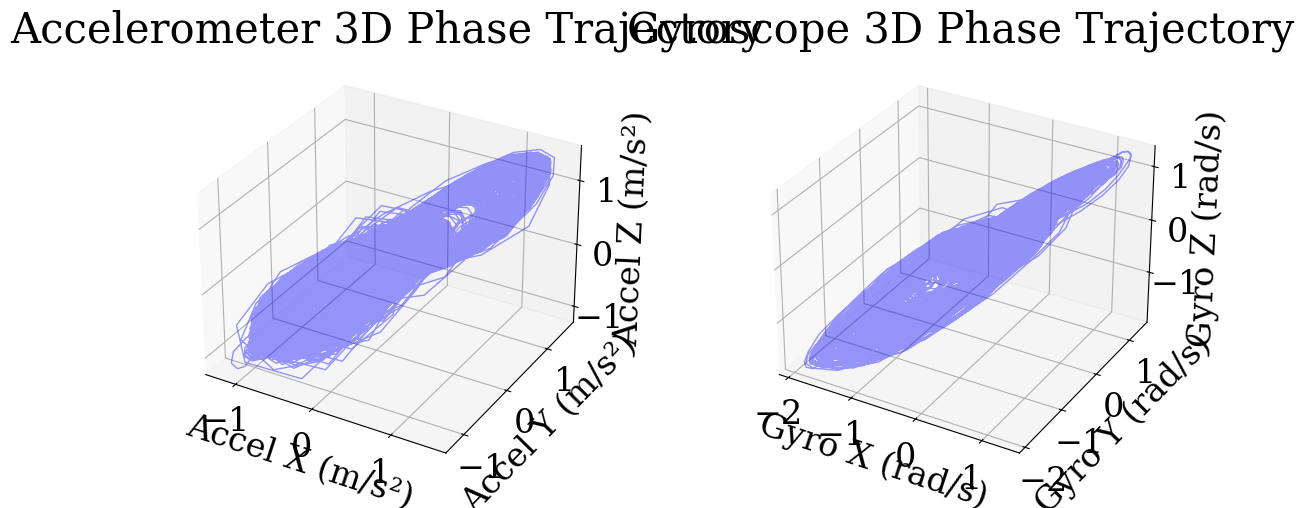

In [59]:
window = 12

plot_imu_phase_trajectory(
    moving_average(acc_1_ica_v2, window),
    moving_average(gyr_1_ica_v3, window),
    scatter=False,
    alpha=0.4
)

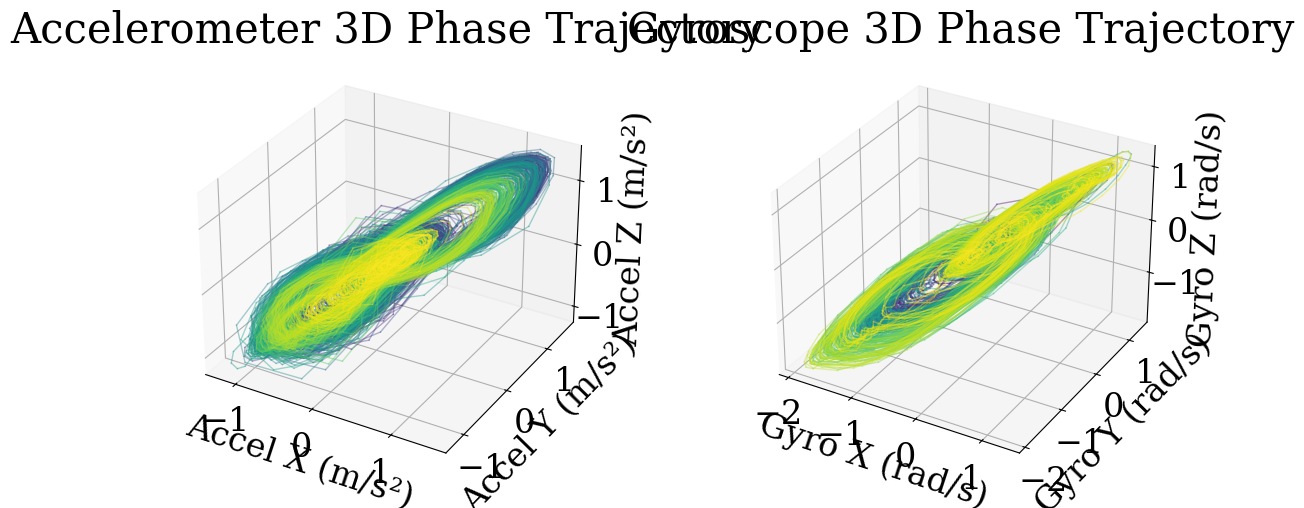

In [60]:
color_plot_imu_phase_trajectory(
    moving_average(acc_1_ica_v2, window),
    moving_average(gyr_1_ica_v3, window),
    scatter=False,
    alpha=0.4
)

Plot ICA for device 2

In [41]:
acc_2_ica = FastICA(n_components=3, random_state=SEED).fit_transform(acc_2)
gyr_2_ica = FastICA(n_components=3, random_state=SEED).fit_transform(gyr_2)

acc_2_ica_v1 = np.lib.stride_tricks.sliding_window_view(acc_2_ica[..., 0], 3)
# acc_2_ica_v2 = np.lib.stride_tricks.sliding_window_view(acc_2_ica[..., 1], 3)
# acc_2_ica_v3 = np.lib.stride_tricks.sliding_window_view(acc_2_ica[..., 2], 3)

# gyr_2_ica_v1 = np.lib.stride_tricks.sliding_window_view(gyr_2_ica[..., 0], 3)
gyr_2_ica_v2 = np.lib.stride_tricks.sliding_window_view(gyr_2_ica[..., 1], 3)
# gyr_2_ica_v3 = np.lib.stride_tricks.sliding_window_view(gyr_2_ica[..., 2], 3)

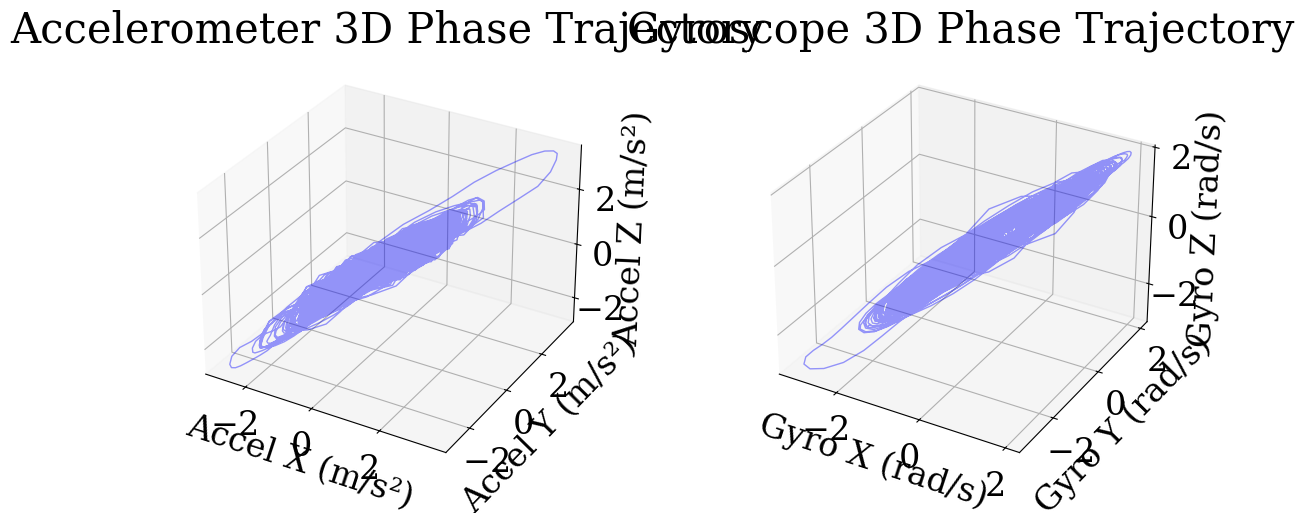

In [56]:
window = 12

plot_imu_phase_trajectory(
    moving_average(acc_2_ica_v1, window),
    moving_average(gyr_2_ica_v2, window),
    scatter=False,
    alpha=0.4
)

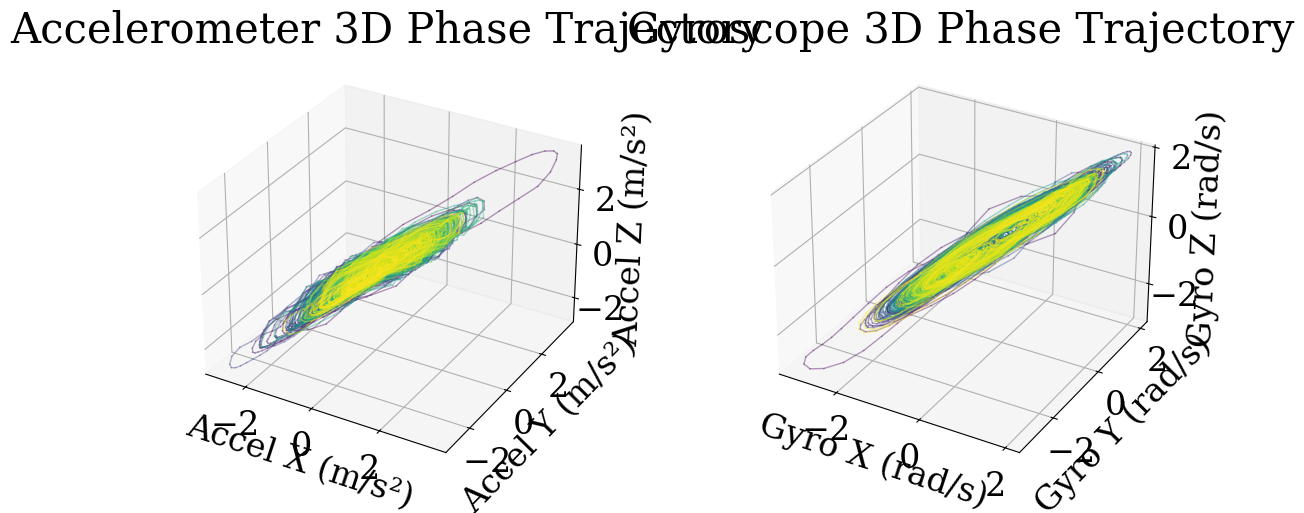

In [61]:
color_plot_imu_phase_trajectory(
    moving_average(acc_2_ica_v1, window),
    moving_average(gyr_2_ica_v2, window),
    scatter=False,
    alpha=0.4
)

## Lagged-CCA

In [17]:
def _deflate(X, Z, w, method):
    """Return X with the rank‑1 influence of score Z removed via weight w."""
    if method == 'projection':
        return X - np.outer(Z, w) / (w @ w)
    if method == 'partial':          # column‑wise regression
        beta = (Z @ X) / (Z @ Z)     # shape (n_features,)
        return X - np.outer(Z, beta)
    raise ValueError("method must be 'projection', 'partial', or 'gram_schmidt'")


# --------------------------------------------------
# τ₋max CCA for **one** component
# --------------------------------------------------

def tau_max_cca_one(X, Y, lag_set, orth_method='projection'):
    """Return best‑lag CCA weights + deflated residuals (centering handled outside)."""
    T, p = X.shape
    _, q = Y.shape
    best_rho, best_tau, best_cca = -1, None, None

    for tau in lag_set:
        X_tau = X[:T - tau] if tau else X
        Y_tau = Y[tau:] if tau else Y
        cca   = CCA(n_components=1, scale=True)
        U, V  = cca.fit_transform(X_tau, Y_tau)
        rho   = np.corrcoef(U[:,0], V[:,0])[0,1]
        if rho > best_rho:
            best_rho, best_tau, best_cca = rho, tau, cca

    # scores on **aligned** slices
    X_tau = X[:T-best_tau] if best_tau else X
    Y_tau = Y[best_tau:]   if best_tau else Y
    Zc = X_tau @ best_cca.x_weights_[:,0]
    Wc = Y_tau @ best_cca.y_weights_[:,0]

    # Extend scores to full length by padding zeros (so shapes match X)
    if best_tau:
        Z_full = np.concatenate([Zc, np.zeros(best_tau)])
        W_full = np.concatenate([np.zeros(best_tau), Wc])
    else:
        Z_full, W_full = Zc, Wc

    X_perp = _deflate(X, Z_full, best_cca.x_weights_[:,0], orth_method)
    Y_perp = _deflate(Y, W_full, best_cca.y_weights_[:,0], orth_method)

    # re‑center residuals to keep mean‑zero property
    X_perp -= X_perp.mean(axis=0)
    Y_perp -= Y_perp.mean(axis=0)

    return {
        'tau_star': best_tau,
        'corr_max': best_rho,
        'a_star':   best_cca.x_weights_[:,0],
        'b_star':   best_cca.y_weights_[:,0],
        'Z_c':      Z_full,
        'W_c':      W_full,
        'X_perp':   X_perp,
        'Y_perp':   Y_perp
    }

# --------------------------------------------------
# Multi‑component extraction
# --------------------------------------------------

def multi_tau_max_cca(X, Y, lag_set, k_components=3, rho_threshold=0.1, orth_method='projection'):
    """Iteratively extract up to k_components causal coordinates."""
    X_res = X - X.mean(axis=0)
    Y_res = Y - Y.mean(axis=0)
    lag_set = set(lag_set)
    
    out = []
    for _ in tqdm.tqdm(range(k_components)):
        comp = tau_max_cca_one(X_res, Y_res, lag_set, orth_method)
        if comp['corr_max'] < rho_threshold:
            break
        out.append(comp)
        X_res, Y_res = comp['X_perp'], comp['Y_perp']
        lag_set.remove(comp['tau_star'])

    # stack results into convenient arrays
    if not out:
        raise RuntimeError('No component exceeded rho_threshold.')

    stacked = {
        'tau_star': np.array([c['tau_star'] for c in out]),
        'corr_max': np.array([c['corr_max'] for c in out]),
        'a_star':   np.stack([c['a_star']   for c in out]),
        'b_star':   np.stack([c['b_star']   for c in out]),
        'Z_c':      np.stack([c['Z_c']      for c in out]),
        'W_c':      np.stack([c['W_c']      for c in out]),
        'X_perp':   np.stack([c['X_perp']   for c in out]),
        'Y_perp':   np.stack([c['Y_perp']   for c in out])
    }
    return stacked


In [18]:
df_x = df_1.iloc[..., 1:]
df_y = df_2_interp.iloc[..., 1:]

cca_on_shifts = multi_tau_max_cca(
    df_x,
    df_y,
    np.arange(0, 20, 2),
    k_components=6,
    rho_threshold=0.1,
    orth_method='projection',
)

  0%|          | 0/6 [00:00<?, ?it/s]

### Check the method on synthetic data

In [19]:
def synthetic_lagged_series(T=1000, p=6, lag1=1, lag2=5, seed=42):
    """
    Generate two 6‑dimensional synthetic time series (X_t, Y_t).
    Y_t is driven by X_{t-lag1} and X_{t-lag2}.

    Parameters
    ----------
    T      : int  – length of the time series
    p      : int  – dimensionality (fixed to 6)
    lag1   : int  – leading lag #1 (positive means X precedes Y)
    lag2   : int  – leading lag #2
    seed   : int  – RNG seed

    Returns
    -------
    DataFrame with columns
        ['t', X0..X5, Y0..Y5]
    """
    rng = np.random.default_rng(seed)
    # base white noise for X
    X = rng.standard_normal((T + lag2, p))
    # coefficients for how X influences Y
    B1 = rng.normal(0.8, 0.1, (p, p))
    
    B2 = rng.normal(0.5, 0.1, (p, p))
    
    # own noise for Y
    noise_Y = rng.standard_normal((T + lag2, p)) * 0.5

    Y = np.zeros_like(X)
    # generate Y with specified lags
    for t in range(max(lag1, lag2), T + lag2):
        Y[t] = (X[t - lag1] @ B1 + X[t - lag2] @ B2 + noise_Y[t])

    # drop first lag2 samples to align
    X = X[lag2:]
    Y = Y[lag2:]
    time = np.arange(T)

    df = pd.DataFrame(
        np.hstack([time[:, None], X, Y]),
        columns=['t'] + [f'X{i}' for i in range(p)] + [f'Y{i}' for i in range(p)]
    )
    return df

# Example usage:
df_synth = synthetic_lagged_series(T=1000)
df_synth.head()


,t,X0,X1,X2,X3,X4,X5,Y0,Y1,Y2,Y3,Y4,Y5
0,0.0,2.141648,-0.406415,-0.512243,-0.813773,0.615979,1.128972,-0.187705,-1.176745,-0.142076,-0.224566,-1.005049,-1.488855
1,1.0,-0.113947,-0.840156,-0.824481,0.650593,0.743254,0.543154,2.145162,3.035175,3.171649,2.244060,2.857624,1.946823
2,2.0,-0.665510,0.232161,0.116686,0.218689,0.871429,0.223596,1.055082,0.164750,-0.328143,-0.724312,-0.917939,1.166161
3,3.0,0.678914,0.067579,0.289119,0.631288,-1.457156,-0.319671,1.043697,0.872074,0.362203,0.970346,2.091004,2.631703
4,4.0,-0.470373,-0.638878,-0.275142,1.494941,-0.865831,0.968278,-0.306063,-0.043931,0.078016,1.046508,0.525784,-0.014677


In [20]:
test_x = df_synth.loc[..., ['X0', 'X1', 'X2', 'X3',	'X4', 'X5']].values
test_y = df_synth.loc[..., ['Y0', 'Y1', 'Y2', 'Y3',	'Y4', 'Y5']].values

test_cca_on_shifts = multi_tau_max_cca(
    test_x,
    test_y,
    np.arange(10),
    k_components=6,
    rho_threshold=0.1,
    orth_method='projection',
)

  0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
test_cca_on_shifts['tau_star'], test_cca_on_shifts['corr_max']

(array([1, 5, 3, 0, 8, 6]),
 array([0.89880669, 0.54680945, 0.15749701, 0.1484697 , 0.12827277,
        0.1269879 ]))

## CCA-based causal embedding

In [72]:
class PureCCA:
    """
    Pure CCA pipeline as a scikit-learn style transformer.

    Parameters
    ----------
    lag_set : sequence of int
        Candidate lags to scan for causal delay.
    d_c : int
        Number of causal dimensions.
    d_hid : int
        Total hidden dimensionality (causal + reconstructive).
    """
    def __init__(self, lag_set, d_c=1, d_hid=3):
        assert d_c <= d_hid, "Causal dim should be <= hidden dim."
        self.lag_set = lag_set
        self.d_c = d_c
        self.d_hid = d_hid
        self.cca_ = None
        self.pca_x_ = None
        self.pca_y_ = None
        self.tau_star_ = None

    def _get_lags(self, X, Y):
        T = len(X)
        X_tau = X[:T - self.tau_star_] if self.tau_star_ else X
        Y_tau = Y[self.tau_star_:] if self.tau_star_ else Y
        return X_tau, Y_tau
        
    def _scan_lagged_cca(
        self, X: np.ndarray, Y: np.ndarray
    ):
        """Return τ⋆ and its first canonical correlation."""
        best_tau, best_rho = None, -np.inf
        T = len(X)
        for tau in self.lag_set:
            Xτ = X[:T - tau] if tau else X
            Yτ = Y[tau:] if tau else Y
            cca = CCA(n_components=1, scale=True)
            u, v = cca.fit_transform(Xτ, Yτ)
            rho = np.corrcoef(u[:, 0], v[:, 0])[0, 1]
            if rho > best_rho:
                best_tau, best_rho = tau, rho

        self.tau_star_ = best_tau

    def _deflate(self, Xc, Yc, cca_proj_x, cca_proj_y, return_padded=False):
        Zc = np.pad(cca_proj_x, ((0, self.tau_star_), (0, 0)), mode="edge")
        Wc = np.pad(cca_proj_y, ((self.tau_star_, 0), (0, 0)), mode="edge")
        
        X_res = Xc - Zc @ self.cca_.x_weights_.T
        Y_res = Yc - Wc @ self.cca_.y_weights_.T

        if return_padded:
            return X_res, Y_res, Zc, Wc
        else:
            return X_res, Y_res
    
    def fit(self, X, Y):
        # center
        T = len(X)
        Xc = X - X.mean(axis=0)
        Yc = Y - Y.mean(axis=0)
        
        # scan lag
        self._scan_lagged_cca(X, Y)
                
        # fit CCA causal block
        X_tau, Y_tau = self._get_lags(Xc, Yc)
        self.cca_ = CCA(n_components=self.d_c, scale=True, max_iter=1000, tol=3e-05)
        U, V = self.cca_.fit_transform(X_tau, Y_tau)

        # deflate
        X_res, Y_res = self._deflate(Xc, Yc, U, V)
        
        # reconstruction PCA
        if isinstance(self.d_hid, (int, np.int32, np.int64)):
            d_res = self.d_hid - self.d_c
            self.pca_x_ = PCA(n_components=d_res, random_state=SEED)
            self.pca_y_ = PCA(n_components=d_res, random_state=SEED)
        elif isinstance(self.d_hid, tuple):
            d_res_x = self.d_hid[0] - self.d_c
            d_res_y = self.d_hid[1] - self.d_c
            self.pca_x_ = PCA(n_components=d_res_x, random_state=SEED)
            self.pca_y_ = PCA(n_components=d_res_y, random_state=SEED)
            
        self.pca_x_.fit(X_res)
        self.pca_y_.fit(Y_res)
        
        return self

    def transform(self, X, Y, split=False):
        """
        Transform new data into [causal, reconstructive] latents.

        Parameters
        ----------
        X, Y : array-like, shape (T, n_x), (T, n_y)
        split : bool
            If True, return Z_c, Z_r, W_c, W_r; else concatenate Z and reconstructive.
        """
        Xc = X - X.mean(axis=0)
        Yc = Y - Y.mean(axis=0)
        T, _ = Xc.shape
        
        # lagged
        X_tau, Y_tau = self._get_lags(Xc, Yc)
        U, V = self.cca_.transform(X_tau, Y_tau)
        
        # deflate
        X_res, Y_res, Zc, Wc = self._deflate(Xc, Yc, U, V, return_padded=True)
        
        Zr = self.pca_x_.transform(X_res)
        Wr = self.pca_y_.transform(Y_res)
        
        if split:
            return Zc, Zr, Wc, Wr
        else:
            return np.hstack([Zc, Zr]), np.hstack([Wc, Wr])

    def fit_transform(self, X, Y, split=False):
        self.fit(X, Y)
        return self.transform(X, Y, split)

    def reconstruct_x(self, X: np.ndarray) -> np.ndarray:
        """
        Given a fitted PureCCA model and original X, reconstruct X from latents:
           X_hat = mean(X) + Z_c @ A_c^T + Z_r @ PCA.components_
        """
        Xc = X - X.mean(axis=0)
        T, _ = Xc.shape
        tau = self.tau_star_
        X_tau = Xc[:T - tau] if tau else Xc
        
        U_c, _ = self.cca_.transform(X_tau, X_tau)
        Zc = np.pad(U_c, ((0, tau), (0, 0)), mode="edge")
        X_res = Xc - Zc @ self.cca_.x_weights_.T
        Zr = self.pca_x_.transform(X_res)
        Xc_hat = Zc @ self.cca_.x_weights_.T + Zr @ self.pca_x_.components_
        X_hat = Xc_hat + X.mean(axis=0)
        return X_hat

    def reconstruct_y(self, Y: np.ndarray) -> np.ndarray:
        """
        Reconstruct Y analogous to X reconstruction.
        """
        Yc = Y - Y.mean(axis=0)
        T, _ = Yc.shape
        tau = self.tau_star_
        Y_tau = Yc[:T - tau] if tau else Xc
        
        _, V_c = self.cca_.transform(Y_tau, Y_tau)
        Wc = np.pad(V_c, ((tau, 0), (0, 0)), mode="edge")
        Y_res = Yc - Wc @ self.cca_.y_weights_.T
        Wr = self.pca_y_.transform(Y_res)
        Yc_hat = Wc @ self.cca_.y_weights_.T + Wr @ self.pca_y_.components_
        Y_hat = Yc_hat + Y.mean(axis=0)
        return Y_hat

In [73]:
df_x = df_1.iloc[..., 1:].values
df_y = df_2_interp.iloc[..., 1:].values

pure_cca = PureCCA(lag_set=np.arange(1), d_c=2, d_hid=4)
pure_cca.fit(df_x, df_y)

x_hidden, y_hidden = pure_cca.transform(df_x, df_y)
x_causal, x_resid, y_causal, y_resid = pure_cca.transform(df_x, df_y, split=True)

In [74]:
assert len(df_x) == len(x_hidden)
assert len(df_y) == len(y_hidden)
assert len(x_hidden) == len(y_hidden)

In [75]:
# temp_x = np.random.rand(1000, 10)
# temp_y = np.random.rand(1000, 10)

# pure_cca = PureCCA(lag_set=np.arange(1), d_c=2, d_hid=4)
# pure_cca.fit(temp_x, temp_y)

# x_hidden, y_hidden = pure_cca.transform(temp_x, temp_y)
# x_causal, x_resid, y_causal, y_resid = pure_cca.transform(temp_x, temp_y, split=True)

# w_causal = pure_cca.cca_.x_weights_
# w_recon = pure_cca.pca_x_.components_.T

# print(w_causal.shape, w_recon.shape)
# w_recon.T @ w_causal

In [77]:
w_causal = pure_cca.cca_.x_weights_
w_recon = pure_cca.pca_x_.components_.T

w_causal.T @ w_recon

array([[ 0.22982506,  0.00481052],
       [-0.55642063,  0.76035752]])

In [71]:
w_causal.T @ w_recon, w_causal @ w_recon.T

(array([[ 0.22982506,  0.00481052],
        [-0.55642063,  0.76035752]]),
 array([[ 0.13037042, -0.17635582, -0.09043137,  0.00302162, -0.00484623,
          0.00702885],
        [ 0.47217302,  0.84935483, -0.01764642,  0.04984464, -0.06786184,
         -0.01482681],
        [-0.14582299,  0.0682172 ,  0.07427847, -0.00675315,  0.00978337,
         -0.00436867],
        [-0.29301352, -0.04137265,  0.11209388, -0.01823455,  0.02569154,
         -0.00394758],
        [ 0.54659044, -0.39569525, -0.30757167,  0.02165319, -0.03193808,
          0.02016499],
        [-0.45391679,  0.21418288,  0.231596  , -0.02097314,  0.03039151,
         -0.01364851]]))

## Quality criterions

### Multicolinearity diagnostics

Condition number of $Z^T Z$ and Variance Inflation Factor (VIF)

VIF, cond.number: lower -- better

In [172]:
def compute_vif(X: np.ndarray) -> pd.DataFrame:
    """
    Compute Variance Inflation Factor (VIF) for each feature in X.
    
    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input data matrix (e.g., latent space representation).
    
    Returns
    -------
    vif_df : pandas DataFrame
        DataFrame with columns ['feature', 'VIF'].
    """
    n_samples, n_features = X.shape
    vif_values = []
    for j in range(n_features):
        # Define feature j as target, others as predictors
        X_j = X[:, j]
        X_others = np.delete(X, j, axis=1)
        
        # Fit linear regression of X_j on X_others
        model = LinearRegression().fit(X_others, X_j)
        r2_j = model.score(X_others, X_j)
        vif_j = 1.0 / (1.0 - r2_j) if r2_j < 1.0 else np.inf
        vif_values.append(vif_j)

    return max(vif_values)

def compute_cond_number(X: np.ndarray) -> float:
    """
    Compute the condition number of X^T X.
    
    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input data matrix.
    
    Returns
    -------
    cond_number : float
        Condition number (ratio of largest to smallest singular value).
    """
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    cond_number = np.log(s.max() / s.min())
    return cond_number

In [173]:
vif_x, vif_y = compute_vif(df_x), compute_vif(df_y)
vif_zx, vif_zy = compute_vif(x_hidden), compute_vif(y_hidden)

print("VIF of the original data:", round(vif_x, 2), round(vif_y, 2))
print("VIF of the latent data:", round(vif_zx, 2), round(vif_zy, 2))

VIF of the original data: 1.63 1.51
VIF of the latent data: 2.06 18.3


In [174]:
cond_x, cond_y = compute_cond_number(df_x), compute_cond_number(df_y)
cond_zx, cond_zy = compute_cond_number(x_hidden), compute_cond_number(y_hidden)

print("Log cond.number of the original data:", round(cond_x, 2), round(cond_y, 2))
print("Log cond.number of the latent data:", round(cond_zx, 2), round(cond_zy, 2))

Log cond.number of the original data: 2.13 3.16
Log cond.number of the latent data: 2.18 3.18


### Reconstruction error

In [175]:
def compute_rmse(X_true: np.ndarray, X_pred: np.ndarray) -> float:
    """
    Compute Root Mean Squared Error between X_true and X_pred.
    """
    return np.sqrt(np.mean((X_true - X_pred) ** 2))


def compute_explained_variance(X_true: np.ndarray, X_pred: np.ndarray) -> float:
    """
    Compute the fraction of variance in X_true explained by X_pred.
    """
    var_true = np.var(X_true, axis=0).sum()
    var_resid = np.var(X_true - X_pred, axis=0).sum()
    return 1 - (var_resid / var_true)

In [176]:
recon_x, recon_y = pure_cca.reconstruct_x(df_x), pure_cca.reconstruct_y(df_y)

rmse_x, rmse_y = compute_rmse(df_x, recon_x), compute_rmse(df_y, recon_y)
expl_var_x, expl_var_y = compute_explained_variance(df_x, recon_x), compute_explained_variance(df_y, recon_y)

print("RMSE of the reconstruction:", round(rmse_x, 2), round(rmse_y, 2))
print("Explained variance ratio:", round(expl_var_x, 2), round(expl_var_y, 2))

RMSE of the reconstruction: 1.6 0.7
Explained variance ratio: 0.83 0.89


### Predictive performance

In [191]:
class DataMode(IntEnum):
    AR_ONLY = 1
    AR_LATENT = 2
    AR_ALL = 3


def build_lagged_features(
        Y: np.ndarray, 
        X: np.ndarray = None, 
        Zc: np.ndarray = None,
        p: int = 1, 
        q: int = 0, 
        mode: DataMode = DataMode.AR_ONLY,
        predict_traj: bool = False
) -> (np.ndarray, np.ndarray):
    """
    Build lagged feature matrix and targets for multivariate time series prediction.
    
    Parameters
    ----------
    Y : ndarray, shape (T, n_y)
        Target time series to predict.
    X : ndarray, shape (T, n_x), optional
        Original feature time series for exogenous variables (if use_latent=False).
    Zc : ndarray, shape (T, d_c), optional
        Causal latent series for exogenous features (if use_latent=True).
    p : int
        Number of autoregressive lags for Y.
    q : int
        Number of exogenous lags (for X or Zc).
    mode : DataMode
        TOFILL.
    
    Returns
    -------
    X_feat : ndarray, shape (N_samples, n_features)
        Lagged feature matrix.
    Y_target : ndarray, shape (N_samples, n_y)
        Targets aligned with feature matrix.
    """
    T, n_y = Y.shape
    max_lag = max(p, q)
    rows = T - max_lag
    
    # Prepare Y lagged features
    # For each t from max_lag to T-1, features are Y[t-1], Y[t-2], ..., Y[t-p]
    Y_lags = []
    for i in range(1, p + 1):
        Y_lags.append(Y[max_lag - i : T - i, :])
    
    Y_lagged = np.hstack(Y_lags)  # shape (rows, n_y * p)
    
    # Prepare exogenous features
    if q > 0 and mode == DataMode.AR_LATENT:
        assert Zc is not None, "Zc must be provided when use_latent=True"
        Ex = []
        for j in range(1, q + 1):
            Ex.append(Zc[max_lag - j : T - j, :])
        X_exog = np.hstack(Ex)  # shape (rows, d_c * q)
    elif q > 0 and mode == DataMode.AR_ALL:
        assert X is not None, "X must be provided when use_latent=False"
        Ex = []
        for j in range(1, q + 1):
            Ex.append(X[max_lag - j : T - j, :])
        X_exog = np.hstack(Ex)  # shape (rows, n_x * q)
    elif mode == DataMode.AR_ONLY:
        X_exog = np.empty((rows, 0))
    
    # Concatenate AR and exogenous features
    if Y_lagged.size and X_exog.size:
        X_feat = np.hstack([Y_lagged, X_exog])
    elif Y_lagged.size:
        X_feat = Y_lagged
    elif X_exog.size:
        X_feat = X_exog
    else:
        raise ValueError("At least one of p>0 or q>0 must hold")

    if predict_traj:
        Y_target = Y_lagged[1:]
        return X_feat[:-1], Y_target
    else:
        Y_target = Y[max_lag:, :]
        return X_feat, Y_target


def bic_from_residuals(residuals: np.ndarray, num_params: int) -> float:
    """
    Compute BIC for a linear regression given the array of residuals.

    Parameters
    ----------
    residuals : np.ndarray
        1D array of length n, the prediction errors y_i - y_i_hat.
    num_params : int
        Total number of free parameters in the model (e.g., p+1 if you have p predictors and an intercept).

    Returns
    -------
    float
        The Bayesian Information Criterion (BIC).
    """
    n = residuals.shape[0]
    
    # 1) Compute RSS = sum(e_i^2)
    rss = np.sum(residuals ** 2)

    # 2) Estimate sigma^2_hat = RSS / n
    sigma2_hat = rss / n

    # 3) Compute log-likelihood for Gaussian residuals
    #    ln(L_hat) = - (n/2) * [ln(2π * sigma2_hat) + 1]
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma2_hat) + 1.0)

    # 4) Compute BIC:
    #    BIC = k * ln(n) - 2 * log_likelihood
    bic_value = num_params * np.log(n) - 2.0 * log_likelihood

    return bic_value


def update_metrics(metrics_dir, y_true, y_pred, **kwargs):
    k_params = kwargs.get('k_params', y_true.shape[1])
    residuals = y_true - y_pred
    
    acc_true, gyr_true = np.split(y_true, 2, axis=1)
    acc_pred, gyr_pred = np.split(y_pred, 2, axis=1)

    acc_magn_true = np.linalg.norm(acc_true, axis=1)
    gyr_magn_true = np.linalg.norm(gyr_true, axis=1)
    acc_magn_pred = np.linalg.norm(acc_pred, axis=1)
    gyr_magn_pred = np.linalg.norm(gyr_pred, axis=1)
    
    metrics_dir['rmse'].append(compute_rmse(y_true, y_pred))
    metrics_dir['magnitude_rmse'].append(
        compute_rmse(acc_magn_true, acc_magn_pred) + compute_rmse(gyr_magn_true, gyr_magn_pred)
    )
    metrics_dir['bic'].append(bic_from_residuals(residuals, k_params))
    metrics_dir['expl_var_ratio'].append(compute_explained_variance(y_true, y_pred))


| PureCCA Training (%) | Model Training (%) | Validation (%) |
| -------------------- | ------------------ | -------------- |
| 0-20                 | 0-30               | 30-40          |
| 0-30                 | 0-40               | 40-50          |
| 0-40                 | 0-50               | 50-60          |
| 0-50                 | 0-60               | 60-70          |
| 0-60                 | 0-70               | 70-80          |

In [192]:
X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, train_size=0.8, shuffle=False)
splitter = TimeSeriesSplit(n_splits=5, test_size=int(0.125*len(X_train)))

# Experiment settings
LAG_SET = np.arange(10)
CAUSAL_DIM = 2
HIDDEN_DIM = 4
AR_LAGS = 5
EXOG_LAGS = 5

linreg_logs = dict()
METRICS = ['rmse', 'magnitude_rmse', 'bic', 'expl_var_ratio']

for data_mode in tqdm.tqdm(DataMode):
    metric_dict = dict()
    for metric_nm in METRICS:
        metric_dict[metric_nm] = list()
    
    for train_index, test_index in splitter.split(X_train):
        test_size = len(test_index)
        purecca_index = train_index[:-test_size]
    
        fold_cca = PureCCA(lag_set=LAG_SET, d_c=CAUSAL_DIM, d_hid=HIDDEN_DIM)
        fold_cca.fit(X_train[purecca_index], Y_train[purecca_index])
        X_c_train, _, _, _ = fold_cca.transform(X_train[train_index], np.zeros_like(Y_train[test_index]), split=True)
        X_c_val, _, _, _ = fold_cca.transform(X_train[test_index], np.zeros_like(Y_train[test_index]), split=True)

        # X_c_train = X_c_train[:-fold_cca.tau_star_] if fold_cca.tau_star_ > 0 else X_c_train
        # X_c_val = X_c_val[:-fold_cca.tau_star_] if fold_cca.tau_star_ > 0 else X_c_val

        # X_c_train = np.pad(X_c_train, ((0, fold_cca.tau_star_), (0, 0)), mode="edge")
        # X_c_val = np.pad(X_c_val, ((0, fold_cca.tau_star_), (0, 0)), mode="edge")
        
        data_train, target_train = build_lagged_features(
            Y=Y_train[train_index],
            X=X_train[train_index],
            Zc=X_c_train,
            p=AR_LAGS,
            q=EXOG_LAGS,
            mode=data_mode
        )
        data_val, target_val = build_lagged_features(
            Y=Y_train[test_index],
            X=X_train[test_index],
            Zc=X_c_val,
            p=AR_LAGS,
            q=EXOG_LAGS,
            mode=data_mode
        )

        linreg = Pipeline([
            ('scaler', StandardScaler()),
            ('linreg', ElasticNet(random_state=SEED))
        ])
    
        linreg.fit(data_train, target_train)
        target_pred = linreg.predict(data_val)
    
        update_metrics(metric_dict, target_val, target_pred, k_params=data_train.shape[1])

    linreg_logs[data_mode.name] = metric_dict

  0%|          | 0/3 [00:00<?, ?it/s]

In [193]:
metrics = [
    ('rmse', "{:.3f} ± {:.3f}"),
    ('magnitude_rmse', "{:.3f} ± {:.3f}"),
    ('bic', "{:.1f} ± {:.1f}"),
    ('expl_var_ratio', "{:.3f} ± {:.3f}")
]

# Build a table: rows = approaches, columns = metrics formatted as strings
rows = []
for approach, values_dict in linreg_logs.items():
    row = {'Approach': approach}
    for metric_name, fmt in metrics:
        vals = np.array(values_dict[metric_name])
        mean = np.mean(vals)
        std = np.std(vals)
        row[metric_name] = fmt.format(mean, std)
    rows.append(row)

df_summary = pd.DataFrame(rows)
df_summary = df_summary[['Approach', 'rmse', 'magnitude_rmse', 'bic', 'expl_var_ratio']]
df_summary.columns = ['Approach', 'RMSE', 'Magnitude RMSE', 'BIC', 'Explained Var.Ratio']

df_summary

,Approach,RMSE,Magnitude RMSE,BIC,Explained Var.Ratio
0,AR_ONLY,1.377 ± 0.059,3.335 ± 0.158,11739.0 ± 187.5,0.606 ± 0.010
1,AR_LATENT,1.336 ± 0.058,3.230 ± 0.151,11685.4 ± 190.9,0.629 ± 0.010
2,AR_ALL,1.310 ± 0.054,3.143 ± 0.135,11752.5 ± 180.1,0.644 ± 0.009


Create a separate function, loop over different p, q and regression models

In [210]:
def instantiate_model(typo: str):
    if typo == "linear":
        return Pipeline([
            ('scaler', StandardScaler()),
            ('linreg', MultiTaskElasticNet(random_state=SEED))
        ])
    elif typo == "knn":
        return Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_jobs=4))
        ])
    elif typo == "boosting":
        return CatBoostRegressor(
            iterations=200,
            depth=6,
            learning_rate=0.05,
            verbose=False,
            loss_function='MultiRMSE',
            task_type='CPU',
        )
    else:
        raise ValueError("Wrong model name")


def cross_validate_all_modes(
    X: np.ndarray,
    Y: np.ndarray,
    lag_set: np.ndarray,
    causal_dim: int,
    hidden_dim: int,
    ar_lags: int,
    exog_lags: int,
    n_splits: int = 5,
    train_ratio: float = 0.8,
    val_size_frac: float = 0.125,
    seed: int = SEED,
    model_nm: str = 'linear',
    model_factory: Callable[[str], Any] = instantiate_model,
    feature_builder: Callable = build_lagged_features
) -> dict:
    # (1) Split off final 20% for a held‐out test (we’ll do that after the CV)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_ratio, shuffle=False)
    splitter = TimeSeriesSplit(n_splits=n_splits, test_size=int(val_size_frac*len(X_train)))

    # Prepare output structure
    quality_criterion_logs_cv = {
        mode.name: {
            'rmse':           [],
            'magnitude_rmse': [],
            'bic':            [],
            'expl_var_ratio': []
        }
        for mode in DataMode
    }

    # (3) Loop over each DataMode
    for mode in DataMode:
        for train_idx, val_idx in splitter.split(X_train):
            # (3a) Further split “train_idx” into:
            #      cca_train_idx = train_idx[ : (len(train_idx) - len(val_idx)) ]
            #      model_train_idx = train_idx
            test_size = len(val_idx)
            cca_train_idx = train_idx[:-test_size]

            # (3b) Fit PureCCA on [0 : cca_train_end]
            cca = PureCCA(lag_set=lag_set, d_c=causal_dim, d_hid=hidden_dim)
            cca.fit(
                X_train[cca_train_idx],
                Y_train[cca_train_idx]
            )

            # (3c) Transform “model_train” window → get Zc_train, Wc_train
            Zc_train, _, _, _ = cca.transform(
                X_train[train_idx],
                Y_train[train_idx],
                split=True
            )
            # (3d) Transform “model_val” window → get Zc_val, Wc_val
            Zc_val, _, _, _ = cca.transform(
                X_train[val_idx],
                Y_train[val_idx],
                split=True
            )

            # (3e) Build lagged features for the (train_idx) and (val_idx) portion
            X_feat_train, Y_target_train = feature_builder(
                Y=Y_train[train_idx],
                X=X_train[train_idx],
                Zc=Zc_train,
                p=ar_lags,
                q=exog_lags,
                mode=mode
            )
            X_feat_val, Y_target_val = feature_builder(
                Y=Y_train[val_idx],
                X=X_train[val_idx],
                Zc=Zc_val,
                p=ar_lags,
                q=exog_lags,
                mode=mode
            )

            # (3f) Re‐create a fresh ElasticNet pipeline inside each fold
            model = model_factory(model_nm)
            model.fit(X_feat_train, Y_target_train)
            Y_pred_val = model.predict(X_feat_val)

            update_metrics(
                quality_criterion_logs_cv[mode.name],
                Y_target_val,
                Y_pred_val,
                k_params=X_feat_train.shape[1]
            )

    return quality_criterion_logs_cv

In [195]:
def test_all_modes(
    X: np.ndarray,
    Y: np.ndarray,
    lag_set: np.ndarray,
    causal_dim: int,
    hidden_dim: int,
    ar_lags: int,
    exog_lags: int,
    n_splits: int = 5,
    train_ratio: float = 0.8,
    seed: int = SEED,
    model_nm: str = 'linear',
    model_factory: Callable[[str], Any] = instantiate_model,
    feature_builder: Callable = build_lagged_features
) -> dict:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_ratio, shuffle=False)
    
    quality_criterion_logs_test = {
        mode.name: {
            'rmse':           [],
            'magnitude_rmse': [],
            'bic':            [],
            'expl_var_ratio': []
        }
        for mode in DataMode
    }

    for mode in DataMode:
        cca = PureCCA(lag_set=lag_set, d_c=causal_dim, d_hid=hidden_dim)
        cca.fit(X_train, Y_train)

        Zc_train, _, _, _ = cca.transform(X_train, Y_train, split=True)
        Zc_test, _, _, _ = cca.transform(X_test, Y_test, split=True)
        
        X_feat_train, Y_target_train = feature_builder(
            Y=Y_train,
            X=X_train,
            Zc=Zc_train,
            p=ar_lags,
            q=exog_lags,
            mode=mode
        )
        X_feat_test, Y_target_test = feature_builder(
            Y=Y_test,
            X=X_test,
            Zc=Zc_test,
            p=ar_lags,
            q=exog_lags,
            mode=mode
        )

        model = model_factory(model_nm)
        model.fit(X_feat_train, Y_target_train)
        Y_pred_test = model.predict(X_feat_test)

        update_metrics(
            quality_criterion_logs_test[mode.name],
            Y_target_test,
            Y_pred_test,
            k_params=X_feat_train.shape[1]
        )

    modified_res = {
        mode: {
            nm: val[0] for nm, val in metric_info.items()
        } for mode, metric_info in quality_criterion_logs_test.items()
    }
    return modified_res

**Loop over ar_dim, exog_dim and models**

In [155]:
LAG_SET = np.arange(10)
CAUSAL_DIM = 2
HIDDEN_DIM = 4

AR_GRID = np.arange(1, 6)
EXOG_GRID = np.arange(1, 15)
MODEL_GRID = ('linear', 'knn', 'boosting')

results = []

for model_nm in tqdm.tqdm(MODEL_GRID):
    for P in tqdm.tqdm(AR_GRID):
        for Q in EXOG_GRID:
            elem_result = test_all_modes(
                df_x,
                df_y,
                lag_set=LAG_SET,
                causal_dim=CAUSAL_DIM,
                hidden_dim=HIDDEN_DIM,
                ar_lags=P,
                exog_lags=Q,
                model_nm=model_nm
            )
            elem_df = pd.DataFrame(elem_result).T.reset_index()
            elem_df['model'] = model_nm
            elem_df['ar'] = P
            elem_df['exog'] = Q
            results.append(elem_df)

results_causal_origin = pd.concat(results, ignore_index=True)
results_causal_origin.to_csv(RESULTS_DIR + 'purecca-origin.csv', index=False)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [156]:
results_causal_origin.drop(columns=['ar', 'exog']).groupby(['model', 'index']).agg(['mean', 'std'])

rmse           magnitude_rmse                     bic  \
                        mean       std           mean       std          mean   
model    index                                                                  
boosting AR_ALL     0.472048  0.024964       0.967893  0.064175  14197.115539   
         AR_LATENT  0.503822  0.045543       1.061035  0.119203  14493.894823   
         AR_ONLY    0.472123  0.041363       0.967958  0.103509  13802.370229   
knn      AR_ALL     0.701063  0.030158       1.354576  0.052319  17659.997149   
         AR_LATENT  0.684209  0.035777       1.341701  0.075289  17192.412531   
         AR_ONLY    0.608065  0.024295       1.170702  0.060252  16039.273409   
linear   AR_ALL     1.135973  0.016599       2.757044  0.055314  21888.739482   
         AR_LATENT  1.196057  0.028560       2.899698  0.066157  22086.368241   
         AR_ONLY    1.197580  0.015658       2.916598  0.062541  21973.573484   

                               expl_var_ratio            
                           std           mean       std  
model    index                                           
boosting AR_ALL     480.801126       0.942612  0.006311  
         AR_LATENT  714.613743       0.934101  0.012489  
         AR_ONLY    670.633782       0.942144  0.010819  
knn      AR_ALL     493.161263       0.872881  0.010846  
         AR_LATENT  427.828193       0.878828  0.013049  
         AR_ONLY    395.036718       0.904792  0.007642  
linear   AR_ALL     140.387575       0.669080  0.010021  
         AR_LATENT  207.376983       0.632023  0.017743  
         AR_ONLY     57.165056       0.631193  0.009753

In [206]:
results_causal_origin.query("exog >= 10").drop(columns=['ar', 'exog']).groupby(['model', 'index']).agg(['mean', 'std'])

rmse           magnitude_rmse                     bic  \
                        mean       std           mean       std          mean   
model    index                                                                  
boosting AR_ALL     0.478119  0.022219       0.988845  0.059052  14524.843734   
         AR_LATENT  0.513118  0.046320       1.091203  0.119956  14716.509277   
         AR_ONLY    0.472309  0.041287       0.968272  0.102344  13793.503348   
knn      AR_ALL     0.718363  0.024208       1.374904  0.045790  18086.231632   
         AR_LATENT  0.698205  0.044195       1.370481  0.091447  17423.662385   
         AR_ONLY    0.608378  0.024588       1.171397  0.060901  16028.485088   
linear   AR_ALL     1.129277  0.011195       2.732669  0.039726  22043.225159   
         AR_LATENT  1.220804  0.022563       2.932255  0.049464  22320.797442   
         AR_ONLY    1.197825  0.015861       2.917139  0.063366  21954.309500   

                               expl_var_ratio            
                           std           mean       std  
model    index                                           
boosting AR_ALL     336.995304       0.941262  0.005805  
         AR_LATENT  688.186323       0.931671  0.012941  
         AR_ONLY    667.112223       0.942102  0.010791  
knn      AR_ALL     262.846101       0.866895  0.009060  
         AR_LATENT  480.183461       0.873721  0.016385  
         AR_ONLY    400.111405       0.904681  0.007740  
linear   AR_ALL      73.437277       0.673508  0.006460  
         AR_LATENT  124.320066       0.616629  0.014243  
         AR_ONLY     54.808629       0.630985  0.009876

**Тот же цикл, но теперь предсказываем элемент фазовой траектории**

In [207]:
LAG_SET = np.arange(10)
CAUSAL_DIM = 2
HIDDEN_DIM = 4

AR_GRID = np.arange(1, 6)
EXOG_GRID = np.arange(1, 15)
MODEL_GRID = ('linear', 'knn', 'boosting')

results = []

for model_nm in tqdm.tqdm(MODEL_GRID):
    for P in tqdm.tqdm(AR_GRID):
        for Q in EXOG_GRID:
            elem_result = test_all_modes(
                df_x,
                df_y,
                lag_set=LAG_SET,
                causal_dim=CAUSAL_DIM,
                hidden_dim=HIDDEN_DIM,
                ar_lags=P,
                exog_lags=Q,
                model_nm=model_nm,
                feature_builder=partial(build_lagged_features, predict_traj=True)
            )
            elem_df = pd.DataFrame(elem_result).T.reset_index()
            elem_df['model'] = model_nm
            elem_df['ar'] = P
            elem_df['exog'] = Q
            results.append(elem_df)

results_causal_origin_traj = pd.concat(results, ignore_index=True)
results_causal_origin_traj.to_csv(RESULTS_DIR + 'purecca-origin-traj.csv', index=False)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [208]:
results_causal_origin_traj.drop(columns=['ar', 'exog']).groupby(['model', 'index']).agg(['mean', 'std'])

rmse           magnitude_rmse                     bic  \
                        mean       std           mean       std          mean   
model    index                                                                  
boosting AR_ALL     0.376253  0.071635       1.159978  0.108237  16274.105529   
         AR_LATENT  0.401350  0.095034       1.249817  0.114325  16520.209126   
         AR_ONLY    0.381141  0.087743       1.163506  0.102600  15952.956032   
knn      AR_ALL     0.630278  0.067606       2.181136  0.435214  20871.097197   
         AR_LATENT  0.593221  0.081118       2.062365  0.358220  20064.144706   
         AR_ONLY    0.502993  0.056933       1.724471  0.313550  18519.816851   
linear   AR_ALL     0.869014  0.161741       3.743910  0.480629  23591.248858   
         AR_LATENT  0.911766  0.178042       3.948494  0.506274  23745.997396   
         AR_ONLY    0.908646  0.175886       3.927481  0.474195  23593.266942   

                                expl_var_ratio            
                            std           mean       std  
model    index                                            
boosting AR_ALL     1502.978096       0.962318  0.015842  
         AR_LATENT  1367.746769       0.956252  0.023121  
         AR_ONLY    1398.641899       0.960619  0.020244  
knn      AR_ALL     1907.276386       0.896349  0.022639  
         AR_LATENT  1628.401551       0.907537  0.026805  
         AR_ONLY    1858.036319       0.934219  0.016106  
linear   AR_ALL     1070.919400       0.799912  0.078431  
         AR_LATENT  1015.603884       0.778322  0.091178  
         AR_ONLY    1002.058528       0.779942  0.089799

In [209]:
results_causal_origin_traj.query("exog >= 10").drop(columns=['ar', 'exog']).groupby(['model', 'index']).agg(['mean', 'std'])

rmse           magnitude_rmse                     bic  \
                        mean       std           mean       std          mean   
model    index                                                                  
boosting AR_ALL     0.380211  0.070935       1.184454  0.109227  16585.041591   
         AR_LATENT  0.406275  0.099629       1.266655  0.108678  16677.968213   
         AR_ONLY    0.381681  0.088473       1.166909  0.105085  15952.470051   
knn      AR_ALL     0.658732  0.058660       2.245060  0.449139  21480.228028   
         AR_LATENT  0.616210  0.087129       2.136552  0.349605  20449.621925   
         AR_ONLY    0.503259  0.057674       1.725491  0.317900  18506.888274   
linear   AR_ALL     0.867136  0.159757       3.732762  0.502110  23782.215175   
         AR_LATENT  0.932780  0.183898       4.026619  0.543593  23998.466517   
         AR_ONLY    0.908830  0.178252       3.928087  0.480561  23572.498391   

                                expl_var_ratio            
                            std           mean       std  
model    index                                            
boosting AR_ALL     1511.716287       0.961642  0.015840  
         AR_LATENT  1336.896197       0.955077  0.024549  
         AR_ONLY    1422.600850       0.960525  0.020429  
knn      AR_ALL     1873.915574       0.887408  0.020622  
         AR_LATENT  1502.903883       0.900208  0.029781  
         AR_ONLY    1882.353677       0.934139  0.016324  
linear   AR_ALL     1102.432953       0.801487  0.076856  
         AR_LATENT  1005.130621       0.768007  0.096053  
         AR_ONLY    1015.755023       0.779816  0.091032

## Model in a state space

In [196]:
def causal_moving_average(data: np.ndarray, window: int) -> np.ndarray:
    if not isinstance(data, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    if data.ndim != 2:
        raise ValueError("Input array must be 2D (T × D).")
    if window < 1:
        raise ValueError("window must be >= 1.")

    T, D = data.shape
    cumsum = np.cumsum(data, axis=0)

    ma = np.zeros_like(data, dtype=float)

    for t in range(T):
        if t < window:
            # average of data[0 : t+1, :]
            # cumsum[t, :] = sum_{k=0}^t data[k, :]
            ma[t, :] = cumsum[t, :] / float(t + 1)
        else:
            # sum over data[t-window+1 : t+1, :]
            # = cumsum[t, :] - cumsum[t-window, :]
            window_sum = cumsum[t, :] - cumsum[t - window, :]
            ma[t, :] = window_sum / float(window)

    return ma

def exp_smoothing(data: np.ndarray, alpha: float) -> np.ndarray:
    if not isinstance(data, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    if data.ndim != 2:
        raise ValueError("Input array must be 2D (T × D).")
    if not (0 < alpha <= 1):
        raise ValueError("alpha must be in (0, 1].")

    T, D = data.shape
    smoothed = np.zeros((T, D), dtype=float)
    smoothed[0, :] = data[0, :]

    for t in range(1, T):
        smoothed[t, :] = alpha * data[t, :] + (1 - alpha) * smoothed[t - 1, :]

    return smoothed

Проверяем работу метода

In [213]:
def build_lag_matrix(
        X: np.ndarray = None, 
        p: int = 1, 
) -> (np.ndarray, np.ndarray):
    assert p > 0, "P should be positive number"
    
    T, n_y = X.shape
    rows = T - p + 1
    
    X_lags = []
    for i in range(1, p + 1):
        X_lags.append(X[p - i : T - i, :])
        
    X_lagged = np.hstack(X_lags)
    return X_lagged

        
def test_all_modes_v2(
    X: np.ndarray,
    Y: np.ndarray,
    lag_set: np.ndarray,
    causal_dim: int,
    hidden_dim: int,
    ar_lags: int,
    exog_lags: int,
    train_ratio: float = 0.8,
    seed: int = SEED,
    model_nm: str = 'linear',
    model_factory: Callable[[str], Any] = instantiate_model,
    predict_traj: bool = False
) -> dict:
    X_lagged, Y_lagged = build_lag_matrix(X, exog_lags), build_lag_matrix(Y, ar_lags)
    shared_len = min(len(X_lagged), len(Y_lagged))
    X_lagged, Y_lagged = X_lagged[-shared_len:], Y_lagged[-shared_len:]
    Y_cut = Y[-shared_len:]
    
    X_emb_train, X_emb_test, Y_emb_train, Y_emb_test = train_test_split(
        X_lagged,
        Y_lagged,
        train_size=train_ratio,
        shuffle=False
    )
    Y_cut_train, Y_cut_test = train_test_split(
        Y_cut,
        train_size=train_ratio,
        shuffle=False
    )
    
    quality_criterion_logs_test = {
        mode.name: {
            'rmse':           [],
            'magnitude_rmse': [],
            'bic':            [],
            'expl_var_ratio': []
        }
        for mode in DataMode
    }

    for mode in DataMode:
        cca = PureCCA(lag_set=lag_set, d_c=causal_dim, d_hid=hidden_dim)
        cca.fit(X_emb_train, Y_emb_train)

        Zc_train, _, _, _ = cca.transform(X_emb_train, Y_emb_train, split=True)
        Zc_test, _, _, _ = cca.transform(X_emb_test, Y_emb_test, split=True)

        if mode == DataMode.AR_LATENT:
            X_feat_train = np.hstack((Zc_train, Y_emb_train))
            X_feat_test = np.hstack((Zc_test, Y_emb_test))
        elif mode == DataMode.AR_ALL:
            X_feat_train = np.hstack((X_emb_train, Y_emb_train))
            X_feat_test = np.hstack((X_emb_test, Y_emb_test))
        elif mode == DataMode.AR_ONLY:
            X_feat_train = Y_emb_train
            X_feat_test = Y_emb_test

        Y_target_train = Y_cut_train
        Y_target_test = Y_cut_test

        if predict_traj:
            X_feat_train = X_feat_train[:-1]
            X_feat_test = X_feat_test[:-1]
            Y_target_train = Y_emb_train[1:]
            Y_target_test = Y_emb_test[1:]

        model = model_factory(model_nm)
        model.fit(X_feat_train, Y_target_train)
        Y_pred_test = model.predict(X_feat_test)

        update_metrics(
            quality_criterion_logs_test[mode.name],
            Y_target_test,
            Y_pred_test,
            k_params=X_feat_train.shape[1]
        )

    modified_res = {
        mode: {
            nm: val[0] for nm, val in metric_info.items()
        } for mode, metric_info in quality_criterion_logs_test.items()
    }
    return modified_res

Causality in the original space

In [198]:
model_nm = 'linear'
P = 3
Q = 12
LAG_SET = np.arange(10)
CAUSAL_DIM = 2
HIDDEN_DIM = 4

elem_result = test_all_modes(
    df_x,
    df_y,
    lag_set=LAG_SET,
    causal_dim=CAUSAL_DIM,
    hidden_dim=HIDDEN_DIM,
    ar_lags=P,
    exog_lags=Q,
    model_nm=model_nm,
)
elem_df = pd.DataFrame(elem_result).T.reset_index()
elem_df

,index,rmse,magnitude_rmse,bic,expl_var_ratio
0,AR_ONLY,1.192613,2.891347,21916.930023,0.634249
1,AR_LATENT,1.218349,2.924798,22304.661548,0.618281
2,AR_ALL,1.124950,2.712506,22010.086264,0.675937


Causality in the state space

In [199]:
model_nm = 'linear'
P = 3
Q = 12
LAG_SET = np.arange(10)
CAUSAL_DIM = min(2*Q, 10)
HIDDEN_DIM = min(4*Q, 15)

elem_result = test_all_modes_v2(
    df_x,
    df_y,
    lag_set=LAG_SET,
    causal_dim=CAUSAL_DIM,
    hidden_dim=HIDDEN_DIM,
    ar_lags=P,
    exog_lags=Q,
    model_nm=model_nm,
)
elem_df = pd.DataFrame(elem_result).T.reset_index()
elem_df

,index,rmse,magnitude_rmse,bic,expl_var_ratio
0,AR_ONLY,1.192177,2.890679,21958.606038,0.634673
1,AR_LATENT,1.101589,2.666532,21350.481999,0.688500
2,AR_ALL,1.124382,2.711442,22049.634035,0.676369


Only lag zero

In [200]:
model_nm = 'linear'
P = 3
Q = 12
LAG_SET = np.arange(1)
CAUSAL_DIM = min(2*Q, 10)
HIDDEN_DIM = min(4*Q, 15)

elem_result = test_all_modes_v2(
    df_x,
    df_y,
    lag_set=LAG_SET,
    causal_dim=CAUSAL_DIM,
    hidden_dim=HIDDEN_DIM,
    ar_lags=P,
    exog_lags=Q,
    model_nm=model_nm,
)
elem_df = pd.DataFrame(elem_result).T.reset_index()
elem_df

,index,rmse,magnitude_rmse,bic,expl_var_ratio
0,AR_ONLY,1.192177,2.890679,21958.606038,0.634673
1,AR_LATENT,1.162354,2.803409,21820.627501,0.652984
2,AR_ALL,1.124382,2.711442,22049.634035,0.676369


Что по итогу?

Если размерность данных небольшая -- то особой разницы нет.

Однако в противном случае, следует применять каузальные модели в скрытом пространстве.

При этом, имеет смысл рассматривать сдвиги временных рядов, так как каузальные связи, в основном, не мгновенные

**Цикл по ar_dim, exog_dim и моделям**

In [201]:
LAG_SET = np.arange(10)

AR_GRID = np.arange(1, 6)
EXOG_GRID = np.arange(1, 15)
MODEL_GRID = ('linear', 'knn', 'boosting')

results = []

for model_nm in tqdm.tqdm(MODEL_GRID):
    for P in tqdm.tqdm(AR_GRID):
        for Q in EXOG_GRID:
            CAUSAL_DIM = min(2*Q, 3*P)
            HIDDEN_DIM = min(4*Q, 5*P)

            try:
                elem_result = test_all_modes_v2(
                    df_x,
                    df_y,
                    lag_set=LAG_SET,
                    causal_dim=CAUSAL_DIM,
                    hidden_dim=HIDDEN_DIM,
                    ar_lags=P,
                    exog_lags=Q,
                    model_nm=model_nm,
                )
            except Exception as e:
                print(e)
                continue
            
            elem_df = pd.DataFrame(elem_result).T.reset_index()
            elem_df['model'] = model_nm
            elem_df['ar'] = P
            elem_df['exog'] = Q
            results.append(elem_df)

results_causal_latent = pd.concat(results, ignore_index=True)
results_causal_latent.to_csv(RESULTS_DIR + 'purecca-latent.csv', index=False)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [203]:
results_causal_latent.drop(columns=['ar', 'exog']).groupby(['model', 'index']).agg(['mean', 'std'])

rmse           magnitude_rmse                     bic  \
                        mean       std           mean       std          mean   
model    index                                                                  
boosting AR_ALL     0.472643  0.024333       0.970210  0.063244  14227.195226   
         AR_LATENT  0.480953  0.037224       0.984655  0.095040  14053.002928   
         AR_ONLY    0.471503  0.041433       0.966612  0.103203  13808.941711   
knn      AR_ALL     0.700595  0.029965       1.353652  0.051970  17677.426760   
         AR_LATENT  0.667686  0.023900       1.305235  0.059349  16944.426044   
         AR_ONLY    0.607670  0.024258       1.169970  0.060188  16054.912521   
linear   AR_ALL     1.135616  0.016691       2.756356  0.055472  21914.645545   
         AR_LATENT  1.147191  0.039040       2.787539  0.105672  21685.369671   
         AR_ONLY    1.197380  0.015657       2.916260  0.062543  22001.353170   

                               expl_var_ratio            
                           std           mean       std  
model    index                                           
boosting AR_ALL     469.076193       0.942492  0.006153  
         AR_LATENT  569.429834       0.940182  0.009791  
         AR_ONLY    672.554583       0.942299  0.010816  
knn      AR_ALL     500.503639       0.873067  0.010755  
         AR_LATENT  364.348360       0.884932  0.008277  
         AR_ONLY    395.862132       0.904926  0.007624  
linear   AR_ALL     151.924348       0.669302  0.010106  
         AR_LATENT  245.814054       0.661515  0.023293  
         AR_ONLY     54.258528       0.631353  0.009746

In [205]:
results_causal_latent.query("exog >= 10").drop(columns=['ar', 'exog']).groupby(['model', 'index']).agg(['mean', 'std'])

rmse           magnitude_rmse                     bic  \
                        mean       std           mean       std          mean   
model    index                                                                  
boosting AR_ALL     0.477789  0.021750       0.990101  0.058566  14548.323625   
         AR_LATENT  0.482216  0.040296       0.986596  0.111034  14083.346830   
         AR_ONLY    0.471689  0.041546       0.967102  0.102693  13810.302142   
knn      AR_ALL     0.717666  0.024131       1.373538  0.045589  18114.469896   
         AR_LATENT  0.660517  0.021324       1.288230  0.056399  16859.902289   
         AR_ONLY    0.607765  0.024547       1.170277  0.060822  16053.132956   
linear   AR_ALL     1.128723  0.011235       2.731632  0.039836  22083.945166   
         AR_LATENT  1.115416  0.026194       2.706600  0.069718  21450.007179   
         AR_ONLY    1.197417  0.015878       2.916503  0.063386  21997.270655   

                               expl_var_ratio            
                           std           mean       std  
model    index                                           
boosting AR_ALL     326.664273       0.941393  0.005673  
         AR_LATENT  602.129563       0.939908  0.010874  
         AR_ONLY    673.595961       0.942265  0.010842  
knn      AR_ALL     265.409171       0.867199  0.009025  
         AR_LATENT  363.846790       0.887566  0.007175  
         AR_ONLY    400.593158       0.904908  0.007716  
linear   AR_ALL      77.330973       0.673907  0.006479  
         AR_LATENT  127.957253       0.680405  0.015290  
         AR_ONLY     54.940786       0.631368  0.009883

**Цикл тот же, но теперь работаем в фазовой траектории**

In [214]:
LAG_SET = np.arange(10)

AR_GRID = np.arange(1, 6)
EXOG_GRID = np.arange(1, 15)
MODEL_GRID = ('linear', 'knn', 'boosting')

results = []

for model_nm in tqdm.tqdm(MODEL_GRID):
    for P in tqdm.tqdm(AR_GRID):
        for Q in EXOG_GRID:
            CAUSAL_DIM = min(2*Q, 3*P)
            HIDDEN_DIM = min(4*Q, 5*P)

            try:
                elem_result = test_all_modes_v2(
                    df_x,
                    df_y,
                    lag_set=LAG_SET,
                    causal_dim=CAUSAL_DIM,
                    hidden_dim=HIDDEN_DIM,
                    ar_lags=P,
                    exog_lags=Q,
                    model_nm=model_nm,
                    predict_traj=True
                )
            except Exception as e:
                print(e)
                continue
            
            elem_df = pd.DataFrame(elem_result).T.reset_index()
            elem_df['model'] = model_nm
            elem_df['ar'] = P
            elem_df['exog'] = Q
            results.append(elem_df)

results_causal_latent_traj = pd.concat(results, ignore_index=True)
results_causal_latent_traj.to_csv(RESULTS_DIR + 'purecca-latent-traj.csv', index=False)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [215]:
results_causal_latent_traj.drop(columns=['ar', 'exog']).groupby(['model', 'index']).agg(['mean', 'std'])

rmse           magnitude_rmse                     bic  \
                        mean       std           mean       std          mean   
model    index                                                                  
boosting AR_ALL     0.385997  0.070642       1.210903  0.117924  16528.731040   
         AR_LATENT  0.394307  0.079646       1.239691  0.143101  16377.598265   
         AR_ONLY    0.386835  0.085022       1.195850  0.113492  16119.726456   
knn      AR_ALL     0.629769  0.067473       2.179383  0.434770  20891.854051   
         AR_LATENT  0.579360  0.052185       2.043363  0.436798  19862.118112   
         AR_ONLY    0.502672  0.056912       1.723431  0.313349  18538.933409   
linear   AR_ALL     0.868676  0.161769       3.742616  0.480211  23618.719068   
         AR_LATENT  0.877538  0.173182       3.776996  0.469263  23377.493810   
         AR_ONLY    0.908445  0.175900       3.926804  0.473935  23622.728865   

                                expl_var_ratio            
                            std           mean       std  
model    index                                            
boosting AR_ALL     1515.402416       0.960431  0.015901  
         AR_LATENT  1550.379817       0.958432  0.018686  
         AR_ONLY    1411.528101       0.959601  0.019757  
knn      AR_ALL     1913.741456       0.896520  0.022557  
         AR_LATENT  2038.251523       0.912831  0.016283  
         AR_ONLY    1861.198950       0.934299  0.016082  
linear   AR_ALL     1074.832194       0.800044  0.078398  
         AR_LATENT  1031.633957       0.794596  0.085613  
         AR_ONLY    1003.996023       0.780027  0.089758

In [216]:
results_causal_latent_traj.query("exog >= 10").drop(columns=['ar', 'exog']).groupby(['model', 'index']).agg(['mean', 'std'])

rmse           magnitude_rmse                     bic  \
                        mean       std           mean       std          mean   
model    index                                                                  
boosting AR_ALL     0.390564  0.071111       1.237973  0.113423  16859.143741   
         AR_LATENT  0.393487  0.083070       1.233023  0.156823  16361.852098   
         AR_ONLY    0.386952  0.086443       1.194584  0.114380  16118.312601   
knn      AR_ALL     0.657984  0.058649       2.242417  0.448508  21514.093806   
         AR_LATENT  0.580584  0.040421       2.052260  0.458423  19903.363772   
         AR_ONLY    0.502754  0.057632       1.723883  0.317616  18536.773035   
linear   AR_ALL     0.866632  0.159775       3.730992  0.501569  23825.645096   
         AR_LATENT  0.857547  0.167696       3.674207  0.461340  23189.948809   
         AR_ONLY    0.908478  0.178258       3.927124  0.480262  23618.344469   

                                expl_var_ratio            
                            std           mean       std  
model    index                                            
boosting AR_ALL     1499.966134       0.959619  0.016165  
         AR_LATENT  1644.403398       0.958578  0.019751  
         AR_ONLY    1440.319287       0.959571  0.020106  
knn      AR_ALL     1877.175466       0.887700  0.020583  
         AR_LATENT  2197.757308       0.912928  0.012599  
         AR_ONLY    1885.939253       0.934289  0.016286  
linear   AR_ALL     1103.931545       0.801739  0.076800  
         AR_LATENT  1069.986380       0.804284  0.080776  
         AR_ONLY    1017.038935       0.780038  0.090959